# Hydrology Experiment
Notebook to run experiments on the hydrology tasks.

Before running this notebook, you need to run the pretraining configurations for Reptile, MAML, and MetaSGD. To do so, execute the following command from the repository root directory:
`python tsfewshot/run_scheduler.py train --directory experiments/hydrology/configs/ --gpu-ids 0 --runs-per-gpu 3`.

Make sure you have placed the data .csv files in `experiments/hydrology/data/multibasin-01031500`.

In [1]:
%load_ext autoreload
%autoreload 2
import copy
import pickle
import sys
import os
from collections import defaultdict
from pathlib import Path

from importlib import reload
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', datefmt='%I:%M:%S')

import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import pandas as pd
import scipy
import torch
from matplotlib import rc
from tqdm import tqdm

sys.path.append('../..')
from tsfewshot.config import Config
from tsfewshot.pcautils import get_best_epoch
from tsfewshot import plot, analyses

np.random.seed(0)
torch.random.manual_seed(0)

DEVICE = 'cuda:0'
SUPPORT_SIZES = [14, 30, 60, 180, 365]
QUERY_SIZE = 9999999  # use all remaining samples as support

CODE_DIR = Path('../..')
DATA_DIR = Path('data/multibasin-01031500/')

rc('text', usetex=True)

In [2]:
# get the run directories from the meta-training phase
RUNS = {
    'reptile': Path('runs/reptile-400basin01031500/hydrology-400basin01031500-reptile-60support6batch10steplr1.0innerlr0.1-finetune10-seed0_220301_031738').resolve(),
    'maml': Path('runs/fomaml-400basin01031500/hydrology-400basin01031500-fomaml-60support6batch5steplr0.01innerlr0.001-finetune5-seed0_220304_081841').resolve(),
    'metasgd': Path('runs/metasgd-400basin01031500/hydrology-400basin01031500-metasgd-60support6batch1steplr0.01innerlr[5e-05, 0.0001]-finetune1-seed0_220304_081635').resolve(),
    'supervised': Path('runs/supervised-400basin01031500/hydrology-01031500-supervised-60support-seed0_220307_095732').resolve(),
    'metacurvature': Path('runs/hydrology-400basin01031500-metacurvature-60support6batch1steplr0.01innerlr1e-05-finetune1-seed0_220422_071138').resolve(),
}

In [3]:
# create tasks on which we will generate the finetuning trajectories that
# will be used to calculate the preconditioning matrix
np.random.seed(0)
   
# we use part of the basins to calculate the preconditioning matrix ("finetune_tasks"),
# part for the gridsearch, and part for the final evaluation.
finetune_tasks = [(f'{t.split("#")[0]}#1990-10-01#1999-09-30',
                   f'{t.split("#")[0]}#1981-10-01#1989-09-30') for t in Config(RUNS['maml']/'config.yml').train_datasets]
gridsearch_tasks = ['14182500_hbvedu_sim.csv#1990-10-01#1999-09-30', '11478500_hbvedu_sim.csv#1990-10-01#1999-09-30', '08175000_hbvedu_sim.csv#1990-10-01#1999-09-30', '08158810_hbvedu_sim.csv#1990-10-01#1999-09-30', '06803510_hbvedu_sim.csv#1990-10-01#1999-09-30', '07184000_hbvedu_sim.csv#1990-10-01#1999-09-30', '08196000_hbvedu_sim.csv#1990-10-01#1999-09-30', '09047700_hbvedu_sim.csv#1990-10-01#1999-09-30', '03291780_hbvedu_sim.csv#1990-10-01#1999-09-30', '01486000_hbvedu_sim.csv#1990-10-01#1999-09-30', '03340800_hbvedu_sim.csv#1990-10-01#1999-09-30', '05591550_hbvedu_sim.csv#1990-10-01#1999-09-30', '05414000_hbvedu_sim.csv#1990-10-01#1999-09-30', '09494000_hbvedu_sim.csv#1990-10-01#1999-09-30', '02046000_hbvedu_sim.csv#1990-10-01#1999-09-30', '12041200_hbvedu_sim.csv#1990-10-01#1999-09-30', '07145700_hbvedu_sim.csv#1990-10-01#1999-09-30', '01350140_hbvedu_sim.csv#1990-10-01#1999-09-30', '01415000_hbvedu_sim.csv#1990-10-01#1999-09-30', '01552500_hbvedu_sim.csv#1990-10-01#1999-09-30', '06846500_hbvedu_sim.csv#1990-10-01#1999-09-30', '11299600_hbvedu_sim.csv#1990-10-01#1999-09-30', '11482500_hbvedu_sim.csv#1990-10-01#1999-09-30', '01547700_hbvedu_sim.csv#1990-10-01#1999-09-30', '01580000_hbvedu_sim.csv#1990-10-01#1999-09-30', '14316700_hbvedu_sim.csv#1990-10-01#1999-09-30', '04161580_hbvedu_sim.csv#1990-10-01#1999-09-30', '08267500_hbvedu_sim.csv#1990-10-01#1999-09-30', '08164300_hbvedu_sim.csv#1990-10-01#1999-09-30', '01137500_hbvedu_sim.csv#1990-10-01#1999-09-30', '04057510_hbvedu_sim.csv#1990-10-01#1999-09-30', '05466500_hbvedu_sim.csv#1990-10-01#1999-09-30', '06918460_hbvedu_sim.csv#1990-10-01#1999-09-30', '02369800_hbvedu_sim.csv#1990-10-01#1999-09-30', '06280300_hbvedu_sim.csv#1990-10-01#1999-09-30', '02074500_hbvedu_sim.csv#1990-10-01#1999-09-30', '11124500_hbvedu_sim.csv#1990-10-01#1999-09-30', '01667500_hbvedu_sim.csv#1990-10-01#1999-09-30', '01439500_hbvedu_sim.csv#1990-10-01#1999-09-30', '01030500_hbvedu_sim.csv#1990-10-01#1999-09-30', '03028000_hbvedu_sim.csv#1990-10-01#1999-09-30', '08194200_hbvedu_sim.csv#1990-10-01#1999-09-30', '01549500_hbvedu_sim.csv#1990-10-01#1999-09-30', '02081500_hbvedu_sim.csv#1990-10-01#1999-09-30', '02381600_hbvedu_sim.csv#1990-10-01#1999-09-30', '09034900_hbvedu_sim.csv#1990-10-01#1999-09-30', '03500000_hbvedu_sim.csv#1990-10-01#1999-09-30', '06889500_hbvedu_sim.csv#1990-10-01#1999-09-30', '07292500_hbvedu_sim.csv#1990-10-01#1999-09-30', '06888500_hbvedu_sim.csv#1990-10-01#1999-09-30']
test_tasks = ['03450000_hbvedu_sim.csv#1990-10-01#1999-09-30', '03357350_hbvedu_sim.csv#1990-10-01#1999-09-30', '04056500_hbvedu_sim.csv#1990-10-01#1999-09-30', '05488200_hbvedu_sim.csv#1990-10-01#1999-09-30', '14216500_hbvedu_sim.csv#1990-10-01#1999-09-30', '04197100_hbvedu_sim.csv#1990-10-01#1999-09-30', '14185900_hbvedu_sim.csv#1990-10-01#1999-09-30', '03144000_hbvedu_sim.csv#1990-10-01#1999-09-30', '04127918_hbvedu_sim.csv#1990-10-01#1999-09-30', '01666500_hbvedu_sim.csv#1990-10-01#1999-09-30', '02430615_hbvedu_sim.csv#1990-10-01#1999-09-30', '07263295_hbvedu_sim.csv#1990-10-01#1999-09-30', '03455500_hbvedu_sim.csv#1990-10-01#1999-09-30', '05495500_hbvedu_sim.csv#1990-10-01#1999-09-30', '08190500_hbvedu_sim.csv#1990-10-01#1999-09-30', '06853800_hbvedu_sim.csv#1990-10-01#1999-09-30', '01664000_hbvedu_sim.csv#1990-10-01#1999-09-30', '02149000_hbvedu_sim.csv#1990-10-01#1999-09-30', '03592718_hbvedu_sim.csv#1990-10-01#1999-09-30', '12145500_hbvedu_sim.csv#1990-10-01#1999-09-30', '09210500_hbvedu_sim.csv#1990-10-01#1999-09-30', '08029500_hbvedu_sim.csv#1990-10-01#1999-09-30', '11475560_hbvedu_sim.csv#1990-10-01#1999-09-30', '07068000_hbvedu_sim.csv#1990-10-01#1999-09-30', '07056000_hbvedu_sim.csv#1990-10-01#1999-09-30', '01557500_hbvedu_sim.csv#1990-10-01#1999-09-30', '06441500_hbvedu_sim.csv#1990-10-01#1999-09-30', '11180960_hbvedu_sim.csv#1990-10-01#1999-09-30', '05408000_hbvedu_sim.csv#1990-10-01#1999-09-30', '05454000_hbvedu_sim.csv#1990-10-01#1999-09-30', '11528700_hbvedu_sim.csv#1990-10-01#1999-09-30', '06278300_hbvedu_sim.csv#1990-10-01#1999-09-30', '12375900_hbvedu_sim.csv#1990-10-01#1999-09-30', '05123400_hbvedu_sim.csv#1990-10-01#1999-09-30', '02481000_hbvedu_sim.csv#1990-10-01#1999-09-30', '04124000_hbvedu_sim.csv#1990-10-01#1999-09-30', '03049000_hbvedu_sim.csv#1990-10-01#1999-09-30', '12451000_hbvedu_sim.csv#1990-10-01#1999-09-30', '02112360_hbvedu_sim.csv#1990-10-01#1999-09-30', '06468170_hbvedu_sim.csv#1990-10-01#1999-09-30', '02312200_hbvedu_sim.csv#1990-10-01#1999-09-30', '06477500_hbvedu_sim.csv#1990-10-01#1999-09-30', '01195100_hbvedu_sim.csv#1990-10-01#1999-09-30', '05057000_hbvedu_sim.csv#1990-10-01#1999-09-30', '03460000_hbvedu_sim.csv#1990-10-01#1999-09-30', '05525500_hbvedu_sim.csv#1990-10-01#1999-09-30', '14185000_hbvedu_sim.csv#1990-10-01#1999-09-30', '08023080_hbvedu_sim.csv#1990-10-01#1999-09-30', '09378630_hbvedu_sim.csv#1990-10-01#1999-09-30', '06289000_hbvedu_sim.csv#1990-10-01#1999-09-30', '06910800_hbvedu_sim.csv#1990-10-01#1999-09-30', '11532500_hbvedu_sim.csv#1990-10-01#1999-09-30', '01365000_hbvedu_sim.csv#1990-10-01#1999-09-30', '03574500_hbvedu_sim.csv#1990-10-01#1999-09-30', '01123000_hbvedu_sim.csv#1990-10-01#1999-09-30', '01333000_hbvedu_sim.csv#1990-10-01#1999-09-30', '04063700_hbvedu_sim.csv#1990-10-01#1999-09-30', '01613050_hbvedu_sim.csv#1990-10-01#1999-09-30', '01639500_hbvedu_sim.csv#1990-10-01#1999-09-30', '11468500_hbvedu_sim.csv#1990-10-01#1999-09-30', '09430600_hbvedu_sim.csv#1990-10-01#1999-09-30', '02324400_hbvedu_sim.csv#1990-10-01#1999-09-30', '08070000_hbvedu_sim.csv#1990-10-01#1999-09-30', '06408700_hbvedu_sim.csv#1990-10-01#1999-09-30', '10242000_hbvedu_sim.csv#1990-10-01#1999-09-30', '06291500_hbvedu_sim.csv#1990-10-01#1999-09-30', '11230500_hbvedu_sim.csv#1990-10-01#1999-09-30', '10259000_hbvedu_sim.csv#1990-10-01#1999-09-30', '12381400_hbvedu_sim.csv#1990-10-01#1999-09-30', '09513780_hbvedu_sim.csv#1990-10-01#1999-09-30', '02055100_hbvedu_sim.csv#1990-10-01#1999-09-30', '01434025_hbvedu_sim.csv#1990-10-01#1999-09-30', '05057200_hbvedu_sim.csv#1990-10-01#1999-09-30', '01518862_hbvedu_sim.csv#1990-10-01#1999-09-30', '01591400_hbvedu_sim.csv#1990-10-01#1999-09-30', '06921070_hbvedu_sim.csv#1990-10-01#1999-09-30', '05593575_hbvedu_sim.csv#1990-10-01#1999-09-30', '09035900_hbvedu_sim.csv#1990-10-01#1999-09-30', '03164000_hbvedu_sim.csv#1990-10-01#1999-09-30', '09484000_hbvedu_sim.csv#1990-10-01#1999-09-30', '12141300_hbvedu_sim.csv#1990-10-01#1999-09-30', '02372250_hbvedu_sim.csv#1990-10-01#1999-09-30', '05087500_hbvedu_sim.csv#1990-10-01#1999-09-30', '04043050_hbvedu_sim.csv#1990-10-01#1999-09-30', '02056900_hbvedu_sim.csv#1990-10-01#1999-09-30', '01568000_hbvedu_sim.csv#1990-10-01#1999-09-30', '01414500_hbvedu_sim.csv#1990-10-01#1999-09-30', '07375000_hbvedu_sim.csv#1990-10-01#1999-09-30', '01583500_hbvedu_sim.csv#1990-10-01#1999-09-30', '02038850_hbvedu_sim.csv#1990-10-01#1999-09-30', '02246000_hbvedu_sim.csv#1990-10-01#1999-09-30', '01170100_hbvedu_sim.csv#1990-10-01#1999-09-30', '04213000_hbvedu_sim.csv#1990-10-01#1999-09-30', '09107000_hbvedu_sim.csv#1990-10-01#1999-09-30', '10205030_hbvedu_sim.csv#1990-10-01#1999-09-30', '12056500_hbvedu_sim.csv#1990-10-01#1999-09-30', '01435000_hbvedu_sim.csv#1990-10-01#1999-09-30', '05595730_hbvedu_sim.csv#1990-10-01#1999-09-30', '03213700_hbvedu_sim.csv#1990-10-01#1999-09-30', '06464500_hbvedu_sim.csv#1990-10-01#1999-09-30', '06352000_hbvedu_sim.csv#1990-10-01#1999-09-30', '03439000_hbvedu_sim.csv#1990-10-01#1999-09-30', '14154500_hbvedu_sim.csv#1990-10-01#1999-09-30', '12115000_hbvedu_sim.csv#1990-10-01#1999-09-30', '14362250_hbvedu_sim.csv#1990-10-01#1999-09-30', '11274630_hbvedu_sim.csv#1990-10-01#1999-09-30', '02198100_hbvedu_sim.csv#1990-10-01#1999-09-30', '09484600_hbvedu_sim.csv#1990-10-01#1999-09-30', '02298608_hbvedu_sim.csv#1990-10-01#1999-09-30', '07148400_hbvedu_sim.csv#1990-10-01#1999-09-30', '01594950_hbvedu_sim.csv#1990-10-01#1999-09-30', '05508805_hbvedu_sim.csv#1990-10-01#1999-09-30', '09378170_hbvedu_sim.csv#1990-10-01#1999-09-30', '03281100_hbvedu_sim.csv#1990-10-01#1999-09-30', '01484100_hbvedu_sim.csv#1990-10-01#1999-09-30', '03182500_hbvedu_sim.csv#1990-10-01#1999-09-30', '05399500_hbvedu_sim.csv#1990-10-01#1999-09-30', '02051500_hbvedu_sim.csv#1990-10-01#1999-09-30', '02152100_hbvedu_sim.csv#1990-10-01#1999-09-30', '11476600_hbvedu_sim.csv#1990-10-01#1999-09-30', '01423000_hbvedu_sim.csv#1990-10-01#1999-09-30', '04115265_hbvedu_sim.csv#1990-10-01#1999-09-30', '01596500_hbvedu_sim.csv#1990-10-01#1999-09-30', '02314500_hbvedu_sim.csv#1990-10-01#1999-09-30', '12488500_hbvedu_sim.csv#1990-10-01#1999-09-30', '10259200_hbvedu_sim.csv#1990-10-01#1999-09-30', '08086290_hbvedu_sim.csv#1990-10-01#1999-09-30', '04127997_hbvedu_sim.csv#1990-10-01#1999-09-30', '02011400_hbvedu_sim.csv#1990-10-01#1999-09-30', '08378500_hbvedu_sim.csv#1990-10-01#1999-09-30', '03346000_hbvedu_sim.csv#1990-10-01#1999-09-30', '04024430_hbvedu_sim.csv#1990-10-01#1999-09-30', '03504000_hbvedu_sim.csv#1990-10-01#1999-09-30', '14138870_hbvedu_sim.csv#1990-10-01#1999-09-30', '07362100_hbvedu_sim.csv#1990-10-01#1999-09-30', '10310500_hbvedu_sim.csv#1990-10-01#1999-09-30', '06344600_hbvedu_sim.csv#1990-10-01#1999-09-30', '06934000_hbvedu_sim.csv#1990-10-01#1999-09-30', '01162500_hbvedu_sim.csv#1990-10-01#1999-09-30', '12388400_hbvedu_sim.csv#1990-10-01#1999-09-30', '04122200_hbvedu_sim.csv#1990-10-01#1999-09-30', '08109700_hbvedu_sim.csv#1990-10-01#1999-09-30', '11522500_hbvedu_sim.csv#1990-10-01#1999-09-30', '06784000_hbvedu_sim.csv#1990-10-01#1999-09-30', '13340600_hbvedu_sim.csv#1990-10-01#1999-09-30', '12010000_hbvedu_sim.csv#1990-10-01#1999-09-30', '03159540_hbvedu_sim.csv#1990-10-01#1999-09-30', '07340300_hbvedu_sim.csv#1990-10-01#1999-09-30', '01539000_hbvedu_sim.csv#1990-10-01#1999-09-30', '09306242_hbvedu_sim.csv#1990-10-01#1999-09-30', '10396000_hbvedu_sim.csv#1990-10-01#1999-09-30', '08103900_hbvedu_sim.csv#1990-10-01#1999-09-30', '14303200_hbvedu_sim.csv#1990-10-01#1999-09-30', '11381500_hbvedu_sim.csv#1990-10-01#1999-09-30', '02415000_hbvedu_sim.csv#1990-10-01#1999-09-30', '03285000_hbvedu_sim.csv#1990-10-01#1999-09-30', '14306500_hbvedu_sim.csv#1990-10-01#1999-09-30', '04015330_hbvedu_sim.csv#1990-10-01#1999-09-30', '02096846_hbvedu_sim.csv#1990-10-01#1999-09-30', '07167500_hbvedu_sim.csv#1990-10-01#1999-09-30', '05495000_hbvedu_sim.csv#1990-10-01#1999-09-30', '01139800_hbvedu_sim.csv#1990-10-01#1999-09-30', '03280700_hbvedu_sim.csv#1990-10-01#1999-09-30', '14305500_hbvedu_sim.csv#1990-10-01#1999-09-30', '08079600_hbvedu_sim.csv#1990-10-01#1999-09-30', '10343500_hbvedu_sim.csv#1990-10-01#1999-09-30', '01139000_hbvedu_sim.csv#1990-10-01#1999-09-30', '01440000_hbvedu_sim.csv#1990-10-01#1999-09-30', '03500240_hbvedu_sim.csv#1990-10-01#1999-09-30', '02464000_hbvedu_sim.csv#1990-10-01#1999-09-30', '12186000_hbvedu_sim.csv#1990-10-01#1999-09-30', '07290650_hbvedu_sim.csv#1990-10-01#1999-09-30', '08189500_hbvedu_sim.csv#1990-10-01#1999-09-30', '07014500_hbvedu_sim.csv#1990-10-01#1999-09-30', '04213075_hbvedu_sim.csv#1990-10-01#1999-09-30', '02479560_hbvedu_sim.csv#1990-10-01#1999-09-30', '01078000_hbvedu_sim.csv#1990-10-01#1999-09-30', '06470800_hbvedu_sim.csv#1990-10-01#1999-09-30', '06903400_hbvedu_sim.csv#1990-10-01#1999-09-30', '02111180_hbvedu_sim.csv#1990-10-01#1999-09-30', '02059500_hbvedu_sim.csv#1990-10-01#1999-09-30', '08158700_hbvedu_sim.csv#1990-10-01#1999-09-30', '03300400_hbvedu_sim.csv#1990-10-01#1999-09-30', '05501000_hbvedu_sim.csv#1990-10-01#1999-09-30', '04224775_hbvedu_sim.csv#1990-10-01#1999-09-30', '09505350_hbvedu_sim.csv#1990-10-01#1999-09-30', '06191500_hbvedu_sim.csv#1990-10-01#1999-09-30', '05291000_hbvedu_sim.csv#1990-10-01#1999-09-30', '06221400_hbvedu_sim.csv#1990-10-01#1999-09-30', '02108000_hbvedu_sim.csv#1990-10-01#1999-09-30', '02349900_hbvedu_sim.csv#1990-10-01#1999-09-30', '08086212_hbvedu_sim.csv#1990-10-01#1999-09-30', '06339100_hbvedu_sim.csv#1990-10-01#1999-09-30', '06847900_hbvedu_sim.csv#1990-10-01#1999-09-30', '10234500_hbvedu_sim.csv#1990-10-01#1999-09-30', '14309500_hbvedu_sim.csv#1990-10-01#1999-09-30', '07071500_hbvedu_sim.csv#1990-10-01#1999-09-30', '07060710_hbvedu_sim.csv#1990-10-01#1999-09-30', '06892000_hbvedu_sim.csv#1990-10-01#1999-09-30', '04040500_hbvedu_sim.csv#1990-10-01#1999-09-30', '13340000_hbvedu_sim.csv#1990-10-01#1999-09-30', '02350900_hbvedu_sim.csv#1990-10-01#1999-09-30', '06332515_hbvedu_sim.csv#1990-10-01#1999-09-30', '02082950_hbvedu_sim.csv#1990-10-01#1999-09-30', '11162500_hbvedu_sim.csv#1990-10-01#1999-09-30', '12414500_hbvedu_sim.csv#1990-10-01#1999-09-30', '06447000_hbvedu_sim.csv#1990-10-01#1999-09-30', '02315500_hbvedu_sim.csv#1990-10-01#1999-09-30', '11383500_hbvedu_sim.csv#1990-10-01#1999-09-30', '08155200_hbvedu_sim.csv#1990-10-01#1999-09-30', '03473000_hbvedu_sim.csv#1990-10-01#1999-09-30', '13310700_hbvedu_sim.csv#1990-10-01#1999-09-30', '02300700_hbvedu_sim.csv#1990-10-01#1999-09-30', '09066200_hbvedu_sim.csv#1990-10-01#1999-09-30', '10336660_hbvedu_sim.csv#1990-10-01#1999-09-30', '08324000_hbvedu_sim.csv#1990-10-01#1999-09-30', '02011460_hbvedu_sim.csv#1990-10-01#1999-09-30', '03488000_hbvedu_sim.csv#1990-10-01#1999-09-30', '01466500_hbvedu_sim.csv#1990-10-01#1999-09-30', '12144000_hbvedu_sim.csv#1990-10-01#1999-09-30', '07057500_hbvedu_sim.csv#1990-10-01#1999-09-30', '05129115_hbvedu_sim.csv#1990-10-01#1999-09-30', '02374500_hbvedu_sim.csv#1990-10-01#1999-09-30', '07196900_hbvedu_sim.csv#1990-10-01#1999-09-30', '09352900_hbvedu_sim.csv#1990-10-01#1999-09-30']

In [4]:
# create finetuning configurations for each of the above finetune_tasks
for method in ['maml', 'reptile', 'supervised']:
    run = RUNS[method]
    best_epoch = get_best_epoch(run)
    lr = '1e-3' if method == 'supervised' else '1e-4'
    (run / f'finetune_epoch{best_epoch}_lr{lr}/configs').mkdir(exist_ok=True, parents=True)

    for task_train, task_val in finetune_tasks:
        cfg = Config(run / 'config.yml')

        cfg.update({
            'experiment_name': f'{cfg.experiment_name}-finetune-{task_train.replace("#", "_")}',
            # this is a quirk of tsfewshot: the "finetune" mode will finetune on the val_datasets
            # and evaluate on the test_datasets
            'val_datasets': [str(task_train)],
            # the "nosupport" flag tells tsfewshot it doesn't need to reserve samples for a support set
            'test_datasets': [str(task_val) + '#nosupport'],
            'finetune_lr': float(lr),
            'optimizer': 'adam',
            'finetune_epochs': 500,
            'eval_every': 1,
            'early_stopping_patience': 10,
            'finetune': False,
            'save_every': 1,
            'support_size': 0,
            'training_setup': 'supervised',
            'batch_size': 64,
            'checkpoint_path': f'{run}/model_epoch{str(best_epoch).zfill(3)}.p',
            'base_run_dir': str(run),
            'run_dir': f'{str(run)}/finetune_epoch{best_epoch}_lr{lr}'
        })

        cfg.dump_config(run / f'finetune_epoch{best_epoch}_lr{lr}/configs/{task_train.replace("#", "_")}.yml')

Next, you need to start the created finetuning runs:
`python tsfewshot/run_scheduler.py finetune --directory /path/to/pretrain_run/finetune_epochX_lrY/configs/ --gpu-ids 0 --runs-per-gpu 5`
(adapt gpu-ids and runs-per-gpu according to the number and size of your GPU(s)).

After all runs are completed, calculate the preconditioning matrix for each pretrained initialization:
`python pca.py --base-dir /path/to/run --finetune-dirs /path/to/run/finetune_epoch*/hbv* --epoch -1`.
This will pickle the preconditioning matrix to `/path/to/run/pca/`.

In [4]:
ft_epochs = defaultdict(lambda: 200)

eval_every = list(range(20)) + list(range(20, 201, 10))
inner_seeds = [0]

type_specs = [
    'pca',  # SubGD
    'normal',  # SGD (Reptile/MAML)
    'normal metasgd',  # MetaSGD
    'normal metacurvature',  # Meta-Curvature
]

gridsearch_dir = 'optimizeFinetune'

def combinations(baseline=None):
    combinations = []
    for type_spec in type_specs:
        if (baseline is not None and baseline not in type_spec) or (baseline is None and type_spec not in ['pca', 'normal']):
            continue
        lrs = [5.0, 2.0, 1.0, 0.5, 0.1, 0.05, 0.01, 0.005]
        if 'pca' not in type_spec:
            lrs += [0.001, 0.0005]
            if 'metacurvature' in type_spec:
                lrs = [l for l in lrs if l < 0.01] + [1e-5, 1e-6]
        else:
            lrs += [20.0, 10.0]
        for support in SUPPORT_SIZES:
            for lr in lrs:
                combinations.append({'support': support,
                                     'lr': lr,
                                     'type': type_spec,
                                     'noise': 0.0,
                                     'sparsity': None,
                                     'interpolate': 1.0,
                                    })
    return combinations
    
len(combinations())

100

In [5]:
# create gridsearch for optimal learning rate and number of update steps during finetuning.
new_runs = []
for method, run in RUNS.items():
    if method in ['metasgd', 'metacurvature']:
        baseline = method
    else:
        baseline = None
    new_runs += analyses.create_gridsearch_dirs(run,
                                                combinations(baseline=baseline),
                                                gridsearch_dir,
                                                inner_seeds,
                                                n_trajectories=-1,
                                                query_size=QUERY_SIZE,
                                                ft_epochs=ft_epochs,
                                                eval_every=eval_every,
                                                save_predictions=False,
                                                optimizer='sgd-squared',
                                                val_datasets=gridsearch_tasks,
                                                pca_file_path=run / 'pca/pca-torchcenterFalseNonecomponentspathNoneimprovedFalseusestepsNonelayerwiseFalse.p')

100%|██████████| 25/25 [00:00<00:00, 1939.98it/s]


Next, run the created gridsearch configurations via:
`python tsfewshot/run_scheduler.py eval --directory /path/to/run/optimizeFinetune/ --epoch -1 --split val --gpu-ids 0 --runs-per-gpu 5`.

In [6]:
best_ft_options = {m: {} for m in RUNS.keys()}
best_ft_epochs = {m: {} for m in RUNS.keys()}
gridsearch_results = {m: {} for m in RUNS.keys()}

In [7]:
# load the gridsearch results and calculate the best learning rate and number of update steps
# for each support size and each method.
# For the best configuration of each support size and method, we create a final finetuning experiment
# that we'll use to analyze the results.
new_run_dirs = []
for method, run in RUNS.items():
    out = analyses.create_final_finetune_dirs([run],
                                              SUPPORT_SIZES,
                                              combinations(baseline=method if method in ['metasgd', 'metacurvature'] \
                                                           else None),
                                              inner_seeds,
                                              gridsearch_dir,
                                              test_tasks,
                                              best_ft_options=best_ft_options[method],
                                              best_ft_epochs=best_ft_epochs[method],
                                              n_results=len(gridsearch_tasks),
                                              tasks_ds_cfg={'save_predictions': True},
                                              metric_aggregation='mean',
                                              metric_name='nse')
    new_run_dirs += out[0]
    best_ft_options[method].update(out[1])
    best_ft_epochs[method].update(out[2])
    gridsearch_results[method].update(out[3])
[r.name for r in new_run_dirs]

14
30
60
180
365
support size: 14   normal noise 0.0                                                                 LR: 0.01   epochs: 19   
support size: 14   pca noise 0.0                                                                    LR: 2.0    epochs: 200  
support size: 30   normal noise 0.0                                                                 LR: 0.05   epochs: 16   
support size: 30   pca noise 0.0                                                                    LR: 10.0   epochs: 30   
support size: 60   normal noise 0.0                                                                 LR: 0.01   epochs: 90   
support size: 60   pca noise 0.0                                                                    LR: 5.0    epochs: 140  
support size: 180  normal noise 0.0                                                                 LR: 0.01   epochs: 170  
support size: 180  pca noise 0.0                                                                    LR: 20.0

[]

## Next, run the final finetuning experiments:
`python tsfewshot/run_scheduler.py eval --directory /path/to/run/optimizeFinetune_finalFinetune/ --epoch -1 --split test --gpu-ids 0 --runs-per-gpu 5`.

In [8]:
# load the result from final finetuning
rc('text', usetex=False)
metrics = {0.0: {}}
for method, run in RUNS.items():
    print(method)
    method_metrics = analyses.get_final_metrics([run],
                                         noises=[0.0],
                                         support_sizes=SUPPORT_SIZES,
                                         combinations=combinations(baseline=method if method in ['metasgd', 'metacurvature'] \
                                                                   else None),
                                         best_ft_options=best_ft_options[method],
                                         inner_seeds=inner_seeds,
                                         query_size=QUERY_SIZE,
                                         n_trajectories=-1,
                                         test_tasks=test_tasks,
                                         gridsearch_dir=gridsearch_dir,
                                         metric_name='nse',
                                         metric_file_name='nse',
                                         metric_aggregation='mean',
                                         no_ft_eval=method not in ['metasgd', 'metacurvature'])
    for k in method_metrics[0.0]:
        method_key = f'{k[1]} {method}' if method not in k[1] else k[1]
        metrics[0.0][(k[0], method_key, k[2])] = method_metrics[0.0][k]
rc('text', usetex=True)

reptile
  0%|          | 0/225 [00:00<?, ?it/s, 01078000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:54 WARNING:Dataset 01078000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  0%|          | 1/225 [00:00<03:24,  1.10it/s, 01123000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:55 WARNING:Dataset 01123000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  0%|          | 1/225 [00:00<03:24,  1.10it/s, 01139000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:55 WARNING:Dataset 01139000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  0%|          | 1/225 [00:01<03:24,  1.10it/s, 01139800_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:55 WARNING:Dataset 01139800_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  2%|▏         | 4/225 [00:01<00:46,  4.79it/s, 01162500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:55 WARNING:Dataset 01162500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  2%|▏         | 4/225 [00:01<00:46,  4.79it/s, 01170100_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:55 WARNING:Dataset 01170100_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  2%|▏         | 4/225 [00:01<00:46,  4.79it/s, 01195100_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:55 WARNING:Dataset 01195100_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  3%|▎         | 7/225 [00:01<00:26,  8.29it/s, 01333000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:55 WARNING:Dataset 01333000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  3%|▎         | 7/225 [00:01<00:26,  8.29it/s, 01365000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:55 WARNING:Dataset 01365000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  3%|▎         | 7/225 [00:01<00:26,  8.29it/s, 01414500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:55 WARNING:Dataset 01414500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  4%|▍         | 10/225 [00:01<00:18, 11.47it/s, 01423000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:55 WARNING:Dataset 01423000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  4%|▍         | 10/225 [00:01<00:18, 11.47it/s, 01434025_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:55 WARNING:Dataset 01434025_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  4%|▍         | 10/225 [00:01<00:18, 11.47it/s, 01435000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:55 WARNING:Dataset 01435000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  6%|▌         | 13/225 [00:01<00:14, 14.15it/s, 01440000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:55 WARNING:Dataset 01440000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  6%|▌         | 13/225 [00:01<00:14, 14.15it/s, 01466500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:55 WARNING:Dataset 01466500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  6%|▌         | 13/225 [00:01<00:14, 14.15it/s, 01484100_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:55 WARNING:Dataset 01484100_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  7%|▋         | 16/225 [00:01<00:12, 16.33it/s, 01518862_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:55 WARNING:Dataset 01518862_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  7%|▋         | 16/225 [00:01<00:12, 16.33it/s, 01539000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:55 WARNING:Dataset 01539000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  7%|▋         | 16/225 [00:01<00:12, 16.33it/s, 01557500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:55 WARNING:Dataset 01557500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  8%|▊         | 19/225 [00:01<00:11, 18.08it/s, 01568000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:55 WARNING:Dataset 01568000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  8%|▊         | 19/225 [00:01<00:11, 18.08it/s, 01583500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:55 WARNING:Dataset 01583500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  8%|▊         | 19/225 [00:01<00:11, 18.08it/s, 01591400_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:55 WARNING:Dataset 01591400_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 10%|▉         | 22/225 [00:01<00:10, 19.40it/s, 01594950_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:55 WARNING:Dataset 01594950_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 10%|▉         | 22/225 [00:01<00:10, 19.40it/s, 01596500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:55 WARNING:Dataset 01596500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 10%|▉         | 22/225 [00:01<00:10, 19.40it/s, 01613050_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:56 WARNING:Dataset 01613050_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 11%|█         | 25/225 [00:01<00:09, 20.35it/s, 01639500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:56 WARNING:Dataset 01639500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 11%|█         | 25/225 [00:02<00:09, 20.35it/s, 01664000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:56 WARNING:Dataset 01664000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 11%|█         | 25/225 [00:02<00:09, 20.35it/s, 01666500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:56 WARNING:Dataset 01666500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 12%|█▏        | 28/225 [00:02<00:09, 21.02it/s, 02011400_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:56 WARNING:Dataset 02011400_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 12%|█▏        | 28/225 [00:02<00:09, 21.02it/s, 02011460_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:56 WARNING:Dataset 02011460_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 12%|█▏        | 28/225 [00:02<00:09, 21.02it/s, 02038850_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:56 WARNING:Dataset 02038850_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 14%|█▍        | 31/225 [00:02<00:08, 21.62it/s, 02051500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:56 WARNING:Dataset 02051500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 14%|█▍        | 31/225 [00:02<00:08, 21.62it/s, 02055100_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:56 WARNING:Dataset 02055100_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 14%|█▍        | 31/225 [00:02<00:08, 21.62it/s, 02056900_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:56 WARNING:Dataset 02056900_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 15%|█▌        | 34/225 [00:02<00:08, 22.05it/s, 02059500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:56 WARNING:Dataset 02059500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 15%|█▌        | 34/225 [00:02<00:08, 22.05it/s, 02082950_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:56 WARNING:Dataset 02082950_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 15%|█▌        | 34/225 [00:02<00:08, 22.05it/s, 02096846_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:56 WARNING:Dataset 02096846_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 16%|█▋        | 37/225 [00:02<00:08, 22.40it/s, 02108000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:56 WARNING:Dataset 02108000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 16%|█▋        | 37/225 [00:02<00:08, 22.40it/s, 02111180_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:56 WARNING:Dataset 02111180_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 16%|█▋        | 37/225 [00:02<00:08, 22.40it/s, 02112360_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:56 WARNING:Dataset 02112360_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 18%|█▊        | 40/225 [00:02<00:08, 22.53it/s, 02149000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:56 WARNING:Dataset 02149000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 18%|█▊        | 40/225 [00:02<00:08, 22.53it/s, 02152100_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:56 WARNING:Dataset 02152100_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 18%|█▊        | 40/225 [00:02<00:08, 22.53it/s, 02198100_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:56 WARNING:Dataset 02198100_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 19%|█▉        | 43/225 [00:02<00:08, 22.70it/s, 02246000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:56 WARNING:Dataset 02246000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 19%|█▉        | 43/225 [00:02<00:08, 22.70it/s, 02298608_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:56 WARNING:Dataset 02298608_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 19%|█▉        | 43/225 [00:02<00:08, 22.70it/s, 02300700_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:56 WARNING:Dataset 02300700_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 20%|██        | 46/225 [00:02<00:07, 22.72it/s, 02312200_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:56 WARNING:Dataset 02312200_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 20%|██        | 46/225 [00:02<00:07, 22.72it/s, 02314500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:57 WARNING:Dataset 02314500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 20%|██        | 46/225 [00:02<00:07, 22.72it/s, 02315500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:57 WARNING:Dataset 02315500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 22%|██▏       | 49/225 [00:03<00:07, 22.68it/s, 02324400_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:57 WARNING:Dataset 02324400_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 22%|██▏       | 49/225 [00:03<00:07, 22.68it/s, 02349900_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:57 WARNING:Dataset 02349900_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 22%|██▏       | 49/225 [00:03<00:07, 22.68it/s, 02350900_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:57 WARNING:Dataset 02350900_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 23%|██▎       | 52/225 [00:03<00:07, 22.83it/s, 02372250_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:57 WARNING:Dataset 02372250_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 23%|██▎       | 52/225 [00:03<00:07, 22.83it/s, 02374500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:57 WARNING:Dataset 02374500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 23%|██▎       | 52/225 [00:03<00:07, 22.83it/s, 02415000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:57 WARNING:Dataset 02415000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 24%|██▍       | 55/225 [00:03<00:07, 22.78it/s, 02430615_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:57 WARNING:Dataset 02430615_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 24%|██▍       | 55/225 [00:03<00:07, 22.78it/s, 02464000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:57 WARNING:Dataset 02464000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 24%|██▍       | 55/225 [00:03<00:07, 22.78it/s, 02479560_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:57 WARNING:Dataset 02479560_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 26%|██▌       | 58/225 [00:03<00:07, 22.59it/s, 02481000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:57 WARNING:Dataset 02481000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 26%|██▌       | 58/225 [00:03<00:07, 22.59it/s, 03049000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:57 WARNING:Dataset 03049000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 26%|██▌       | 58/225 [00:03<00:07, 22.59it/s, 03144000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:57 WARNING:Dataset 03144000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 27%|██▋       | 61/225 [00:03<00:07, 22.52it/s, 03159540_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:57 WARNING:Dataset 03159540_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 27%|██▋       | 61/225 [00:03<00:07, 22.52it/s, 03164000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:57 WARNING:Dataset 03164000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 27%|██▋       | 61/225 [00:03<00:07, 22.52it/s, 03182500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:57 WARNING:Dataset 03182500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 28%|██▊       | 64/225 [00:03<00:07, 22.51it/s, 03213700_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:57 WARNING:Dataset 03213700_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 28%|██▊       | 64/225 [00:03<00:07, 22.51it/s, 03280700_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:57 WARNING:Dataset 03280700_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 28%|██▊       | 64/225 [00:03<00:07, 22.51it/s, 03281100_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:57 WARNING:Dataset 03281100_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 30%|██▉       | 67/225 [00:03<00:07, 22.54it/s, 03285000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:57 WARNING:Dataset 03285000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 30%|██▉       | 67/225 [00:03<00:07, 22.54it/s, 03300400_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:57 WARNING:Dataset 03300400_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 30%|██▉       | 67/225 [00:03<00:07, 22.54it/s, 03346000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:57 WARNING:Dataset 03346000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 31%|███       | 70/225 [00:03<00:06, 22.55it/s, 03357350_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:58 WARNING:Dataset 03357350_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 31%|███       | 70/225 [00:03<00:06, 22.55it/s, 03439000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:58 WARNING:Dataset 03439000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 31%|███       | 70/225 [00:04<00:06, 22.55it/s, 03450000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:58 WARNING:Dataset 03450000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 32%|███▏      | 73/225 [00:04<00:06, 22.67it/s, 03455500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:58 WARNING:Dataset 03455500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 32%|███▏      | 73/225 [00:04<00:06, 22.67it/s, 03460000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:58 WARNING:Dataset 03460000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 32%|███▏      | 73/225 [00:04<00:06, 22.67it/s, 03473000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:58 WARNING:Dataset 03473000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 34%|███▍      | 76/225 [00:04<00:06, 22.65it/s, 03488000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:58 WARNING:Dataset 03488000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 34%|███▍      | 76/225 [00:04<00:06, 22.65it/s, 03500240_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:58 WARNING:Dataset 03500240_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 34%|███▍      | 76/225 [00:04<00:06, 22.65it/s, 03504000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:58 WARNING:Dataset 03504000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 35%|███▌      | 79/225 [00:04<00:06, 22.54it/s, 03574500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:58 WARNING:Dataset 03574500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 35%|███▌      | 79/225 [00:04<00:06, 22.54it/s, 03592718_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:58 WARNING:Dataset 03592718_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 35%|███▌      | 79/225 [00:04<00:06, 22.54it/s, 04015330_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:58 WARNING:Dataset 04015330_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 36%|███▋      | 82/225 [00:04<00:06, 22.63it/s, 04024430_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:58 WARNING:Dataset 04024430_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 36%|███▋      | 82/225 [00:04<00:06, 22.63it/s, 04040500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:58 WARNING:Dataset 04040500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 36%|███▋      | 82/225 [00:04<00:06, 22.63it/s, 04043050_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:58 WARNING:Dataset 04043050_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 38%|███▊      | 85/225 [00:04<00:06, 22.65it/s, 04056500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:58 WARNING:Dataset 04056500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 38%|███▊      | 85/225 [00:04<00:06, 22.65it/s, 04063700_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:58 WARNING:Dataset 04063700_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 38%|███▊      | 85/225 [00:04<00:06, 22.65it/s, 04115265_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:58 WARNING:Dataset 04115265_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 39%|███▉      | 88/225 [00:04<00:06, 22.62it/s, 04122200_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:58 WARNING:Dataset 04122200_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 39%|███▉      | 88/225 [00:04<00:06, 22.62it/s, 04124000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:58 WARNING:Dataset 04124000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 39%|███▉      | 88/225 [00:04<00:06, 22.62it/s, 04127918_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:58 WARNING:Dataset 04127918_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 40%|████      | 91/225 [00:04<00:05, 22.65it/s, 04127997_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:58 WARNING:Dataset 04127997_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 40%|████      | 91/225 [00:04<00:05, 22.65it/s, 04197100_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:59 WARNING:Dataset 04197100_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 40%|████      | 91/225 [00:04<00:05, 22.65it/s, 04213000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:59 WARNING:Dataset 04213000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 42%|████▏     | 94/225 [00:05<00:05, 22.34it/s, 04213075_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:59 WARNING:Dataset 04213075_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 42%|████▏     | 94/225 [00:05<00:05, 22.34it/s, 04224775_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:59 WARNING:Dataset 04224775_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 42%|████▏     | 94/225 [00:05<00:05, 22.34it/s, 05057000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:59 WARNING:Dataset 05057000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 43%|████▎     | 97/225 [00:05<00:05, 22.35it/s, 05057200_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:59 WARNING:Dataset 05057200_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 43%|████▎     | 97/225 [00:05<00:05, 22.35it/s, 05087500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:59 WARNING:Dataset 05087500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 43%|████▎     | 97/225 [00:05<00:05, 22.35it/s, 05123400_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:59 WARNING:Dataset 05123400_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 44%|████▍     | 100/225 [00:05<00:05, 22.47it/s, 05129115_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:59 WARNING:Dataset 05129115_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 44%|████▍     | 100/225 [00:05<00:05, 22.47it/s, 05291000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:59 WARNING:Dataset 05291000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 44%|████▍     | 100/225 [00:05<00:05, 22.47it/s, 05399500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:59 WARNING:Dataset 05399500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 46%|████▌     | 103/225 [00:05<00:05, 22.56it/s, 05408000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:59 WARNING:Dataset 05408000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 46%|████▌     | 103/225 [00:05<00:05, 22.56it/s, 05454000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:59 WARNING:Dataset 05454000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 46%|████▌     | 103/225 [00:05<00:05, 22.56it/s, 05488200_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:59 WARNING:Dataset 05488200_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 47%|████▋     | 106/225 [00:05<00:05, 22.59it/s, 05495000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:59 WARNING:Dataset 05495000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 47%|████▋     | 106/225 [00:05<00:05, 22.59it/s, 05495500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:59 WARNING:Dataset 05495500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 47%|████▋     | 106/225 [00:05<00:05, 22.59it/s, 05501000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:59 WARNING:Dataset 05501000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 48%|████▊     | 109/225 [00:05<00:05, 22.61it/s, 05508805_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:59 WARNING:Dataset 05508805_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 48%|████▊     | 109/225 [00:05<00:05, 22.61it/s, 05525500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:59 WARNING:Dataset 05525500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 48%|████▊     | 109/225 [00:05<00:05, 22.61it/s, 05593575_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:59 WARNING:Dataset 05593575_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 50%|████▉     | 112/225 [00:05<00:04, 22.69it/s, 05595730_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:59 WARNING:Dataset 05595730_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 50%|████▉     | 112/225 [00:05<00:04, 22.69it/s, 06191500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:59 WARNING:Dataset 06191500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 50%|████▉     | 112/225 [00:05<00:04, 22.69it/s, 06221400_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:36:59 WARNING:Dataset 06221400_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 51%|█████     | 115/225 [00:05<00:04, 22.75it/s, 06278300_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:00 WARNING:Dataset 06278300_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 51%|█████     | 115/225 [00:05<00:04, 22.75it/s, 06289000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:00 WARNING:Dataset 06289000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 51%|█████     | 115/225 [00:06<00:04, 22.75it/s, 06291500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:00 WARNING:Dataset 06291500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 52%|█████▏    | 118/225 [00:06<00:04, 22.79it/s, 06332515_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:00 WARNING:Dataset 06332515_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 52%|█████▏    | 118/225 [00:06<00:04, 22.79it/s, 06339100_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:00 WARNING:Dataset 06339100_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 52%|█████▏    | 118/225 [00:06<00:04, 22.79it/s, 06344600_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:00 WARNING:Dataset 06344600_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 54%|█████▍    | 121/225 [00:06<00:04, 22.76it/s, 06352000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:00 WARNING:Dataset 06352000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 54%|█████▍    | 121/225 [00:06<00:04, 22.76it/s, 06408700_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:00 WARNING:Dataset 06408700_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 54%|█████▍    | 121/225 [00:06<00:04, 22.76it/s, 06441500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:00 WARNING:Dataset 06441500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 55%|█████▌    | 124/225 [00:06<00:04, 22.80it/s, 06447000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:00 WARNING:Dataset 06447000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 55%|█████▌    | 124/225 [00:06<00:04, 22.80it/s, 06464500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:00 WARNING:Dataset 06464500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 55%|█████▌    | 124/225 [00:06<00:04, 22.80it/s, 06468170_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:00 WARNING:Dataset 06468170_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 56%|█████▋    | 127/225 [00:06<00:04, 22.72it/s, 06470800_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:00 WARNING:Dataset 06470800_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 56%|█████▋    | 127/225 [00:06<00:04, 22.72it/s, 06477500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:00 WARNING:Dataset 06477500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 56%|█████▋    | 127/225 [00:06<00:04, 22.72it/s, 06784000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:00 WARNING:Dataset 06784000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 58%|█████▊    | 130/225 [00:06<00:04, 22.73it/s, 06847900_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:00 WARNING:Dataset 06847900_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 58%|█████▊    | 130/225 [00:06<00:04, 22.73it/s, 06853800_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:00 WARNING:Dataset 06853800_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 58%|█████▊    | 130/225 [00:06<00:04, 22.73it/s, 06892000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:00 WARNING:Dataset 06892000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 59%|█████▉    | 133/225 [00:06<00:04, 22.75it/s, 06903400_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:00 WARNING:Dataset 06903400_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 59%|█████▉    | 133/225 [00:06<00:04, 22.75it/s, 06910800_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:00 WARNING:Dataset 06910800_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 59%|█████▉    | 133/225 [00:06<00:04, 22.75it/s, 06921070_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:00 WARNING:Dataset 06921070_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 60%|██████    | 136/225 [00:06<00:03, 22.72it/s, 06934000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:00 WARNING:Dataset 06934000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 60%|██████    | 136/225 [00:06<00:03, 22.72it/s, 07014500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:00 WARNING:Dataset 07014500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 60%|██████    | 136/225 [00:06<00:03, 22.72it/s, 07056000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:01 WARNING:Dataset 07056000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 62%|██████▏   | 139/225 [00:06<00:03, 22.75it/s, 07057500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:01 WARNING:Dataset 07057500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 62%|██████▏   | 139/225 [00:07<00:03, 22.75it/s, 07060710_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:01 WARNING:Dataset 07060710_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 62%|██████▏   | 139/225 [00:07<00:03, 22.75it/s, 07068000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:01 WARNING:Dataset 07068000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 63%|██████▎   | 142/225 [00:07<00:03, 22.66it/s, 07071500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:01 WARNING:Dataset 07071500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 63%|██████▎   | 142/225 [00:07<00:03, 22.66it/s, 07148400_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:01 WARNING:Dataset 07148400_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 63%|██████▎   | 142/225 [00:07<00:03, 22.66it/s, 07167500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:01 WARNING:Dataset 07167500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 64%|██████▍   | 145/225 [00:07<00:03, 22.73it/s, 07196900_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:01 WARNING:Dataset 07196900_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 64%|██████▍   | 145/225 [00:07<00:03, 22.73it/s, 07263295_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:01 WARNING:Dataset 07263295_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 64%|██████▍   | 145/225 [00:07<00:03, 22.73it/s, 07290650_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:01 WARNING:Dataset 07290650_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 66%|██████▌   | 148/225 [00:07<00:03, 22.81it/s, 07340300_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:01 WARNING:Dataset 07340300_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 66%|██████▌   | 148/225 [00:07<00:03, 22.81it/s, 07362100_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:01 WARNING:Dataset 07362100_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 66%|██████▌   | 148/225 [00:07<00:03, 22.81it/s, 07375000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:01 WARNING:Dataset 07375000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 67%|██████▋   | 151/225 [00:07<00:03, 22.75it/s, 08023080_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:01 WARNING:Dataset 08023080_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 67%|██████▋   | 151/225 [00:07<00:03, 22.75it/s, 08029500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:01 WARNING:Dataset 08029500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 67%|██████▋   | 151/225 [00:07<00:03, 22.75it/s, 08070000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:01 WARNING:Dataset 08070000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 68%|██████▊   | 154/225 [00:07<00:03, 22.69it/s, 08079600_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:01 WARNING:Dataset 08079600_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 68%|██████▊   | 154/225 [00:07<00:03, 22.69it/s, 08086212_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:01 WARNING:Dataset 08086212_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 68%|██████▊   | 154/225 [00:07<00:03, 22.69it/s, 08086290_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:01 WARNING:Dataset 08086290_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 70%|██████▉   | 157/225 [00:07<00:02, 22.76it/s, 08103900_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:01 WARNING:Dataset 08103900_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 70%|██████▉   | 157/225 [00:07<00:02, 22.76it/s, 08109700_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:01 WARNING:Dataset 08109700_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 70%|██████▉   | 157/225 [00:07<00:02, 22.76it/s, 08155200_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:01 WARNING:Dataset 08155200_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 71%|███████   | 160/225 [00:07<00:02, 22.81it/s, 08158700_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:02 WARNING:Dataset 08158700_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 71%|███████   | 160/225 [00:07<00:02, 22.81it/s, 08189500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:02 WARNING:Dataset 08189500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 71%|███████   | 160/225 [00:08<00:02, 22.81it/s, 08190500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:02 WARNING:Dataset 08190500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 72%|███████▏  | 163/225 [00:08<00:02, 22.78it/s, 08324000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:02 WARNING:Dataset 08324000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 72%|███████▏  | 163/225 [00:08<00:02, 22.78it/s, 08378500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:02 WARNING:Dataset 08378500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 72%|███████▏  | 163/225 [00:08<00:02, 22.78it/s, 09035900_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:02 WARNING:Dataset 09035900_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 74%|███████▍  | 166/225 [00:08<00:02, 22.74it/s, 09066200_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:02 WARNING:Dataset 09066200_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 74%|███████▍  | 166/225 [00:08<00:02, 22.74it/s, 09107000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:02 WARNING:Dataset 09107000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 74%|███████▍  | 166/225 [00:08<00:02, 22.74it/s, 09210500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:02 WARNING:Dataset 09210500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 75%|███████▌  | 169/225 [00:08<00:02, 22.73it/s, 09306242_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:02 WARNING:Dataset 09306242_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 75%|███████▌  | 169/225 [00:08<00:02, 22.73it/s, 09352900_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:02 WARNING:Dataset 09352900_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 75%|███████▌  | 169/225 [00:08<00:02, 22.73it/s, 09378170_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:02 WARNING:Dataset 09378170_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 76%|███████▋  | 172/225 [00:08<00:02, 22.72it/s, 09378630_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:02 WARNING:Dataset 09378630_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 76%|███████▋  | 172/225 [00:08<00:02, 22.72it/s, 09430600_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:02 WARNING:Dataset 09430600_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 76%|███████▋  | 172/225 [00:08<00:02, 22.72it/s, 09484000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:02 WARNING:Dataset 09484000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 78%|███████▊  | 175/225 [00:08<00:02, 22.74it/s, 09484600_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:02 WARNING:Dataset 09484600_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 78%|███████▊  | 175/225 [00:08<00:02, 22.74it/s, 09505350_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:02 WARNING:Dataset 09505350_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 78%|███████▊  | 175/225 [00:08<00:02, 22.74it/s, 09513780_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:02 WARNING:Dataset 09513780_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 79%|███████▉  | 178/225 [00:08<00:02, 22.61it/s, 10205030_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:02 WARNING:Dataset 10205030_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 79%|███████▉  | 178/225 [00:08<00:02, 22.61it/s, 10234500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:02 WARNING:Dataset 10234500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 79%|███████▉  | 178/225 [00:08<00:02, 22.61it/s, 10242000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:02 WARNING:Dataset 10242000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 80%|████████  | 181/225 [00:08<00:01, 22.61it/s, 10259000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:02 WARNING:Dataset 10259000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 80%|████████  | 181/225 [00:08<00:01, 22.61it/s, 10259200_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:02 WARNING:Dataset 10259200_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 80%|████████  | 181/225 [00:08<00:01, 22.61it/s, 10310500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:03 WARNING:Dataset 10310500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 82%|████████▏ | 184/225 [00:08<00:01, 22.74it/s, 10336660_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:03 WARNING:Dataset 10336660_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 82%|████████▏ | 184/225 [00:09<00:01, 22.74it/s, 10343500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:03 WARNING:Dataset 10343500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 82%|████████▏ | 184/225 [00:09<00:01, 22.74it/s, 10396000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:03 WARNING:Dataset 10396000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 83%|████████▎ | 187/225 [00:09<00:01, 22.79it/s, 11162500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:03 WARNING:Dataset 11162500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 83%|████████▎ | 187/225 [00:09<00:01, 22.79it/s, 11180960_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:03 WARNING:Dataset 11180960_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 83%|████████▎ | 187/225 [00:09<00:01, 22.79it/s, 11230500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:03 WARNING:Dataset 11230500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 84%|████████▍ | 190/225 [00:09<00:01, 22.83it/s, 11274630_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:03 WARNING:Dataset 11274630_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 84%|████████▍ | 190/225 [00:09<00:01, 22.83it/s, 11381500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:03 WARNING:Dataset 11381500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 84%|████████▍ | 190/225 [00:09<00:01, 22.83it/s, 11383500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:03 WARNING:Dataset 11383500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 86%|████████▌ | 193/225 [00:09<00:01, 22.91it/s, 11468500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:03 WARNING:Dataset 11468500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 86%|████████▌ | 193/225 [00:09<00:01, 22.91it/s, 11475560_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:03 WARNING:Dataset 11475560_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 86%|████████▌ | 193/225 [00:09<00:01, 22.91it/s, 11476600_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:03 WARNING:Dataset 11476600_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 87%|████████▋ | 196/225 [00:09<00:01, 22.88it/s, 11522500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:03 WARNING:Dataset 11522500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 87%|████████▋ | 196/225 [00:09<00:01, 22.88it/s, 11528700_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:03 WARNING:Dataset 11528700_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 87%|████████▋ | 196/225 [00:09<00:01, 22.88it/s, 11532500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:03 WARNING:Dataset 11532500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 88%|████████▊ | 199/225 [00:09<00:01, 22.89it/s, 12010000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:03 WARNING:Dataset 12010000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 88%|████████▊ | 199/225 [00:09<00:01, 22.89it/s, 12056500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:03 WARNING:Dataset 12056500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 88%|████████▊ | 199/225 [00:09<00:01, 22.89it/s, 12115000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:03 WARNING:Dataset 12115000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 90%|████████▉ | 202/225 [00:09<00:01, 22.84it/s, 12141300_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:03 WARNING:Dataset 12141300_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 90%|████████▉ | 202/225 [00:09<00:01, 22.84it/s, 12144000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:03 WARNING:Dataset 12144000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 90%|████████▉ | 202/225 [00:09<00:01, 22.84it/s, 12145500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:03 WARNING:Dataset 12145500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 91%|█████████ | 205/225 [00:09<00:00, 22.75it/s, 12186000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:03 WARNING:Dataset 12186000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 91%|█████████ | 205/225 [00:09<00:00, 22.75it/s, 12375900_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:04 WARNING:Dataset 12375900_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 91%|█████████ | 205/225 [00:09<00:00, 22.75it/s, 12381400_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:04 WARNING:Dataset 12381400_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 92%|█████████▏| 208/225 [00:10<00:00, 22.81it/s, 12388400_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:04 WARNING:Dataset 12388400_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 92%|█████████▏| 208/225 [00:10<00:00, 22.81it/s, 12414500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:04 WARNING:Dataset 12414500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 92%|█████████▏| 208/225 [00:10<00:00, 22.81it/s, 12451000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:04 WARNING:Dataset 12451000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 94%|█████████▍| 211/225 [00:10<00:00, 22.69it/s, 12488500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:04 WARNING:Dataset 12488500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 94%|█████████▍| 211/225 [00:10<00:00, 22.69it/s, 13310700_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:04 WARNING:Dataset 13310700_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 94%|█████████▍| 211/225 [00:10<00:00, 22.69it/s, 13340000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:04 WARNING:Dataset 13340000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 95%|█████████▌| 214/225 [00:10<00:00, 22.65it/s, 13340600_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:04 WARNING:Dataset 13340600_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 95%|█████████▌| 214/225 [00:10<00:00, 22.65it/s, 14138870_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:04 WARNING:Dataset 14138870_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 95%|█████████▌| 214/225 [00:10<00:00, 22.65it/s, 14154500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:04 WARNING:Dataset 14154500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 96%|█████████▋| 217/225 [00:10<00:00, 22.62it/s, 14185000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:04 WARNING:Dataset 14185000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 96%|█████████▋| 217/225 [00:10<00:00, 22.62it/s, 14185900_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:04 WARNING:Dataset 14185900_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 96%|█████████▋| 217/225 [00:10<00:00, 22.62it/s, 14216500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:04 WARNING:Dataset 14216500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 98%|█████████▊| 220/225 [00:10<00:00, 22.60it/s, 14303200_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:04 WARNING:Dataset 14303200_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 98%|█████████▊| 220/225 [00:10<00:00, 22.60it/s, 14305500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:04 WARNING:Dataset 14305500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 98%|█████████▊| 220/225 [00:10<00:00, 22.60it/s, 14306500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:04 WARNING:Dataset 14306500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 99%|█████████▉| 223/225 [00:10<00:00, 22.59it/s, 14309500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:04 WARNING:Dataset 14309500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 99%|█████████▉| 223/225 [00:10<00:00, 22.59it/s, 14362250_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:37:04 WARNING:Dataset 14362250_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


Plot: 100%|██████████| 225/225 [06:13<00:00,  1.66s/it, 14362250_hbvedu_sim.csv#1990-10-01#1999-09-30]    
14
30
60
180
365
maml
  0%|          | 0/225 [00:00<?, ?it/s, 01078000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:19 WARNING:Dataset 01078000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  0%|          | 0/225 [00:00<?, ?it/s, 01123000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:19 WARNING:Dataset 01123000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  0%|          | 0/225 [00:00<?, ?it/s, 01139000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:19 WARNING:Dataset 01139000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  1%|▏         | 3/225 [00:00<00:09, 22.52it/s, 01139800_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:19 WARNING:Dataset 01139800_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  1%|▏         | 3/225 [00:00<00:09, 22.52it/s, 01162500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:19 WARNING:Dataset 01162500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  1%|▏         | 3/225 [00:00<00:09, 22.52it/s, 01170100_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:19 WARNING:Dataset 01170100_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  3%|▎         | 6/225 [00:00<00:09, 22.88it/s, 01195100_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:19 WARNING:Dataset 01195100_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  3%|▎         | 6/225 [00:00<00:09, 22.88it/s, 01333000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:19 WARNING:Dataset 01333000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  3%|▎         | 6/225 [00:00<00:09, 22.88it/s, 01365000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:19 WARNING:Dataset 01365000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  4%|▍         | 9/225 [00:00<00:09, 22.96it/s, 01414500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:19 WARNING:Dataset 01414500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  4%|▍         | 9/225 [00:00<00:09, 22.96it/s, 01423000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:20 WARNING:Dataset 01423000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  4%|▍         | 9/225 [00:00<00:09, 22.96it/s, 01434025_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:20 WARNING:Dataset 01434025_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  5%|▌         | 12/225 [00:00<00:09, 23.06it/s, 01435000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:20 WARNING:Dataset 01435000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  5%|▌         | 12/225 [00:00<00:09, 23.06it/s, 01440000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:20 WARNING:Dataset 01440000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  5%|▌         | 12/225 [00:00<00:09, 23.06it/s, 01466500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:20 WARNING:Dataset 01466500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  7%|▋         | 15/225 [00:00<00:09, 22.90it/s, 01484100_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:20 WARNING:Dataset 01484100_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  7%|▋         | 15/225 [00:00<00:09, 22.90it/s, 01518862_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:20 WARNING:Dataset 01518862_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  7%|▋         | 15/225 [00:00<00:09, 22.90it/s, 01539000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:20 WARNING:Dataset 01539000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  8%|▊         | 18/225 [00:00<00:09, 22.54it/s, 01557500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:20 WARNING:Dataset 01557500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  8%|▊         | 18/225 [00:00<00:09, 22.54it/s, 01568000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:20 WARNING:Dataset 01568000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  8%|▊         | 18/225 [00:00<00:09, 22.54it/s, 01583500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:20 WARNING:Dataset 01583500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  9%|▉         | 21/225 [00:00<00:09, 22.10it/s, 01591400_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:20 WARNING:Dataset 01591400_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  9%|▉         | 21/225 [00:00<00:09, 22.10it/s, 01594950_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:20 WARNING:Dataset 01594950_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  9%|▉         | 21/225 [00:01<00:09, 22.10it/s, 01596500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:20 WARNING:Dataset 01596500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 11%|█         | 24/225 [00:01<00:09, 22.18it/s, 01613050_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:20 WARNING:Dataset 01613050_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 11%|█         | 24/225 [00:01<00:09, 22.18it/s, 01639500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:20 WARNING:Dataset 01639500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 11%|█         | 24/225 [00:01<00:09, 22.18it/s, 01664000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:20 WARNING:Dataset 01664000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 12%|█▏        | 27/225 [00:01<00:08, 22.37it/s, 01666500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:20 WARNING:Dataset 01666500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 12%|█▏        | 27/225 [00:01<00:08, 22.37it/s, 02011400_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:20 WARNING:Dataset 02011400_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 12%|█▏        | 27/225 [00:01<00:08, 22.37it/s, 02011460_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:20 WARNING:Dataset 02011460_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 13%|█▎        | 30/225 [00:01<00:08, 22.53it/s, 02038850_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:20 WARNING:Dataset 02038850_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 13%|█▎        | 30/225 [00:01<00:08, 22.53it/s, 02051500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:20 WARNING:Dataset 02051500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 13%|█▎        | 30/225 [00:01<00:08, 22.53it/s, 02055100_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:20 WARNING:Dataset 02055100_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 15%|█▍        | 33/225 [00:01<00:08, 22.72it/s, 02056900_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:21 WARNING:Dataset 02056900_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 15%|█▍        | 33/225 [00:01<00:08, 22.72it/s, 02059500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:21 WARNING:Dataset 02059500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 15%|█▍        | 33/225 [00:01<00:08, 22.72it/s, 02082950_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:21 WARNING:Dataset 02082950_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 16%|█▌        | 36/225 [00:01<00:08, 22.78it/s, 02096846_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:21 WARNING:Dataset 02096846_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 16%|█▌        | 36/225 [00:01<00:08, 22.78it/s, 02108000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:21 WARNING:Dataset 02108000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 16%|█▌        | 36/225 [00:01<00:08, 22.78it/s, 02111180_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:21 WARNING:Dataset 02111180_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 17%|█▋        | 39/225 [00:01<00:08, 22.16it/s, 02112360_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:21 WARNING:Dataset 02112360_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 17%|█▋        | 39/225 [00:01<00:08, 22.16it/s, 02149000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:21 WARNING:Dataset 02149000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 17%|█▋        | 39/225 [00:01<00:08, 22.16it/s, 02152100_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:21 WARNING:Dataset 02152100_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 19%|█▊        | 42/225 [00:01<00:08, 22.36it/s, 02198100_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:21 WARNING:Dataset 02198100_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 19%|█▊        | 42/225 [00:01<00:08, 22.36it/s, 02246000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:21 WARNING:Dataset 02246000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 19%|█▊        | 42/225 [00:01<00:08, 22.36it/s, 02298608_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:21 WARNING:Dataset 02298608_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 20%|██        | 45/225 [00:02<00:08, 22.29it/s, 02300700_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:21 WARNING:Dataset 02300700_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 20%|██        | 45/225 [00:02<00:08, 22.29it/s, 02312200_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:21 WARNING:Dataset 02312200_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 20%|██        | 45/225 [00:02<00:08, 22.29it/s, 02314500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:21 WARNING:Dataset 02314500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 21%|██▏       | 48/225 [00:02<00:07, 22.44it/s, 02315500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:21 WARNING:Dataset 02315500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 21%|██▏       | 48/225 [00:02<00:07, 22.44it/s, 02324400_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:21 WARNING:Dataset 02324400_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 21%|██▏       | 48/225 [00:02<00:07, 22.44it/s, 02349900_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:21 WARNING:Dataset 02349900_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 23%|██▎       | 51/225 [00:02<00:07, 22.33it/s, 02350900_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:21 WARNING:Dataset 02350900_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 23%|██▎       | 51/225 [00:02<00:07, 22.33it/s, 02372250_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:21 WARNING:Dataset 02372250_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 23%|██▎       | 51/225 [00:02<00:07, 22.33it/s, 02374500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:21 WARNING:Dataset 02374500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 24%|██▍       | 54/225 [00:02<00:07, 22.49it/s, 02415000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:21 WARNING:Dataset 02415000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 24%|██▍       | 54/225 [00:02<00:07, 22.49it/s, 02430615_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:22 WARNING:Dataset 02430615_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 24%|██▍       | 54/225 [00:02<00:07, 22.49it/s, 02464000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:22 WARNING:Dataset 02464000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 25%|██▌       | 57/225 [00:02<00:07, 22.38it/s, 02479560_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:22 WARNING:Dataset 02479560_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 25%|██▌       | 57/225 [00:02<00:07, 22.38it/s, 02481000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:22 WARNING:Dataset 02481000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 25%|██▌       | 57/225 [00:02<00:07, 22.38it/s, 03049000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:22 WARNING:Dataset 03049000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 27%|██▋       | 60/225 [00:02<00:07, 22.51it/s, 03144000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:22 WARNING:Dataset 03144000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 27%|██▋       | 60/225 [00:02<00:07, 22.51it/s, 03159540_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:22 WARNING:Dataset 03159540_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 27%|██▋       | 60/225 [00:02<00:07, 22.51it/s, 03164000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:22 WARNING:Dataset 03164000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 28%|██▊       | 63/225 [00:02<00:07, 22.28it/s, 03182500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:22 WARNING:Dataset 03182500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 28%|██▊       | 63/225 [00:02<00:07, 22.28it/s, 03213700_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:22 WARNING:Dataset 03213700_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 28%|██▊       | 63/225 [00:02<00:07, 22.28it/s, 03280700_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:22 WARNING:Dataset 03280700_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 29%|██▉       | 66/225 [00:02<00:07, 22.41it/s, 03281100_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:22 WARNING:Dataset 03281100_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 29%|██▉       | 66/225 [00:02<00:07, 22.41it/s, 03285000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:22 WARNING:Dataset 03285000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 29%|██▉       | 66/225 [00:03<00:07, 22.41it/s, 03300400_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:22 WARNING:Dataset 03300400_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 31%|███       | 69/225 [00:03<00:07, 22.21it/s, 03346000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:22 WARNING:Dataset 03346000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 31%|███       | 69/225 [00:03<00:07, 22.21it/s, 03357350_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:22 WARNING:Dataset 03357350_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 31%|███       | 69/225 [00:03<00:07, 22.21it/s, 03439000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:22 WARNING:Dataset 03439000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 32%|███▏      | 72/225 [00:03<00:06, 22.38it/s, 03450000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:22 WARNING:Dataset 03450000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 32%|███▏      | 72/225 [00:03<00:06, 22.38it/s, 03455500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:22 WARNING:Dataset 03455500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 32%|███▏      | 72/225 [00:03<00:06, 22.38it/s, 03460000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:22 WARNING:Dataset 03460000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 33%|███▎      | 75/225 [00:03<00:06, 22.20it/s, 03473000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:22 WARNING:Dataset 03473000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 33%|███▎      | 75/225 [00:03<00:06, 22.20it/s, 03488000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:22 WARNING:Dataset 03488000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 33%|███▎      | 75/225 [00:03<00:06, 22.20it/s, 03500240_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:22 WARNING:Dataset 03500240_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 35%|███▍      | 78/225 [00:03<00:06, 22.14it/s, 03504000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:23 WARNING:Dataset 03504000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 35%|███▍      | 78/225 [00:03<00:06, 22.14it/s, 03574500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:23 WARNING:Dataset 03574500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 35%|███▍      | 78/225 [00:03<00:06, 22.14it/s, 03592718_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:23 WARNING:Dataset 03592718_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 36%|███▌      | 81/225 [00:03<00:06, 22.40it/s, 04015330_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:23 WARNING:Dataset 04015330_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 36%|███▌      | 81/225 [00:03<00:06, 22.40it/s, 04024430_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:23 WARNING:Dataset 04024430_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 36%|███▌      | 81/225 [00:03<00:06, 22.40it/s, 04040500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:23 WARNING:Dataset 04040500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 37%|███▋      | 84/225 [00:03<00:06, 22.12it/s, 04043050_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:23 WARNING:Dataset 04043050_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 37%|███▋      | 84/225 [00:03<00:06, 22.12it/s, 04056500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:23 WARNING:Dataset 04056500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 37%|███▋      | 84/225 [00:03<00:06, 22.12it/s, 04063700_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:23 WARNING:Dataset 04063700_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 39%|███▊      | 87/225 [00:03<00:06, 21.63it/s, 04115265_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:23 WARNING:Dataset 04115265_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 39%|███▊      | 87/225 [00:03<00:06, 21.63it/s, 04122200_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:23 WARNING:Dataset 04122200_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 39%|███▊      | 87/225 [00:03<00:06, 21.63it/s, 04124000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:23 WARNING:Dataset 04124000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 40%|████      | 90/225 [00:04<00:06, 21.85it/s, 04127918_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:23 WARNING:Dataset 04127918_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 40%|████      | 90/225 [00:04<00:06, 21.85it/s, 04127997_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:23 WARNING:Dataset 04127997_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 40%|████      | 90/225 [00:04<00:06, 21.85it/s, 04197100_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:23 WARNING:Dataset 04197100_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 41%|████▏     | 93/225 [00:04<00:06, 21.79it/s, 04213000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:23 WARNING:Dataset 04213000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 41%|████▏     | 93/225 [00:04<00:06, 21.79it/s, 04213075_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:23 WARNING:Dataset 04213075_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 41%|████▏     | 93/225 [00:04<00:06, 21.79it/s, 04224775_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:23 WARNING:Dataset 04224775_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 43%|████▎     | 96/225 [00:04<00:05, 22.25it/s, 05057000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:23 WARNING:Dataset 05057000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 43%|████▎     | 96/225 [00:04<00:05, 22.25it/s, 05057200_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:23 WARNING:Dataset 05057200_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 43%|████▎     | 96/225 [00:04<00:05, 22.25it/s, 05087500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:23 WARNING:Dataset 05087500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 44%|████▍     | 99/225 [00:04<00:05, 21.81it/s, 05123400_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:24 WARNING:Dataset 05123400_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 44%|████▍     | 99/225 [00:04<00:05, 21.81it/s, 05129115_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:24 WARNING:Dataset 05129115_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 44%|████▍     | 99/225 [00:04<00:05, 21.81it/s, 05291000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:24 WARNING:Dataset 05291000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 45%|████▌     | 102/225 [00:04<00:05, 21.79it/s, 05399500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:24 WARNING:Dataset 05399500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 45%|████▌     | 102/225 [00:04<00:05, 21.79it/s, 05408000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:24 WARNING:Dataset 05408000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 45%|████▌     | 102/225 [00:04<00:05, 21.79it/s, 05454000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:24 WARNING:Dataset 05454000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 47%|████▋     | 105/225 [00:04<00:05, 21.81it/s, 05488200_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:24 WARNING:Dataset 05488200_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 47%|████▋     | 105/225 [00:04<00:05, 21.81it/s, 05495000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:24 WARNING:Dataset 05495000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 47%|████▋     | 105/225 [00:04<00:05, 21.81it/s, 05495500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:24 WARNING:Dataset 05495500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 48%|████▊     | 108/225 [00:04<00:05, 21.80it/s, 05501000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:24 WARNING:Dataset 05501000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 48%|████▊     | 108/225 [00:04<00:05, 21.80it/s, 05508805_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:24 WARNING:Dataset 05508805_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 48%|████▊     | 108/225 [00:04<00:05, 21.80it/s, 05525500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:24 WARNING:Dataset 05525500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 49%|████▉     | 111/225 [00:04<00:05, 22.14it/s, 05593575_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:24 WARNING:Dataset 05593575_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 49%|████▉     | 111/225 [00:05<00:05, 22.14it/s, 05595730_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:24 WARNING:Dataset 05595730_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 49%|████▉     | 111/225 [00:05<00:05, 22.14it/s, 06191500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:24 WARNING:Dataset 06191500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 51%|█████     | 114/225 [00:05<00:05, 21.85it/s, 06221400_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:24 WARNING:Dataset 06221400_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 51%|█████     | 114/225 [00:05<00:05, 21.85it/s, 06278300_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:24 WARNING:Dataset 06278300_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 51%|█████     | 114/225 [00:05<00:05, 21.85it/s, 06289000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:24 WARNING:Dataset 06289000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 52%|█████▏    | 117/225 [00:05<00:04, 21.85it/s, 06291500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:24 WARNING:Dataset 06291500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 52%|█████▏    | 117/225 [00:05<00:04, 21.85it/s, 06332515_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:24 WARNING:Dataset 06332515_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 52%|█████▏    | 117/225 [00:05<00:04, 21.85it/s, 06339100_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:24 WARNING:Dataset 06339100_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 53%|█████▎    | 120/225 [00:05<00:04, 21.65it/s, 06344600_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:24 WARNING:Dataset 06344600_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 53%|█████▎    | 120/225 [00:05<00:04, 21.65it/s, 06352000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:25 WARNING:Dataset 06352000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 53%|█████▎    | 120/225 [00:05<00:04, 21.65it/s, 06408700_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:25 WARNING:Dataset 06408700_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 55%|█████▍    | 123/225 [00:05<00:04, 21.78it/s, 06441500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:25 WARNING:Dataset 06441500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 55%|█████▍    | 123/225 [00:05<00:04, 21.78it/s, 06447000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:25 WARNING:Dataset 06447000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 55%|█████▍    | 123/225 [00:05<00:04, 21.78it/s, 06464500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:25 WARNING:Dataset 06464500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 56%|█████▌    | 126/225 [00:05<00:04, 21.79it/s, 06468170_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:25 WARNING:Dataset 06468170_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 56%|█████▌    | 126/225 [00:05<00:04, 21.79it/s, 06470800_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:25 WARNING:Dataset 06470800_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 56%|█████▌    | 126/225 [00:05<00:04, 21.79it/s, 06477500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:25 WARNING:Dataset 06477500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 57%|█████▋    | 129/225 [00:05<00:04, 21.72it/s, 06784000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:25 WARNING:Dataset 06784000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 57%|█████▋    | 129/225 [00:05<00:04, 21.72it/s, 06847900_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:25 WARNING:Dataset 06847900_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 57%|█████▋    | 129/225 [00:05<00:04, 21.72it/s, 06853800_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:25 WARNING:Dataset 06853800_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 59%|█████▊    | 132/225 [00:05<00:04, 21.18it/s, 06892000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:25 WARNING:Dataset 06892000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 59%|█████▊    | 132/225 [00:06<00:04, 21.18it/s, 06903400_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:25 WARNING:Dataset 06903400_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 59%|█████▊    | 132/225 [00:06<00:04, 21.18it/s, 06910800_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:25 WARNING:Dataset 06910800_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 60%|██████    | 135/225 [00:06<00:04, 21.35it/s, 06921070_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:25 WARNING:Dataset 06921070_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 60%|██████    | 135/225 [00:06<00:04, 21.35it/s, 06934000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:25 WARNING:Dataset 06934000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 60%|██████    | 135/225 [00:06<00:04, 21.35it/s, 07014500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:25 WARNING:Dataset 07014500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 61%|██████▏   | 138/225 [00:06<00:04, 21.32it/s, 07056000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:25 WARNING:Dataset 07056000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 61%|██████▏   | 138/225 [00:06<00:04, 21.32it/s, 07057500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:25 WARNING:Dataset 07057500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 61%|██████▏   | 138/225 [00:06<00:04, 21.32it/s, 07060710_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:25 WARNING:Dataset 07060710_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 63%|██████▎   | 141/225 [00:06<00:03, 21.42it/s, 07068000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:25 WARNING:Dataset 07068000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 63%|██████▎   | 141/225 [00:06<00:03, 21.42it/s, 07071500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:25 WARNING:Dataset 07071500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 63%|██████▎   | 141/225 [00:06<00:03, 21.42it/s, 07148400_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:26 WARNING:Dataset 07148400_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 64%|██████▍   | 144/225 [00:06<00:03, 21.56it/s, 07167500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:26 WARNING:Dataset 07167500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 64%|██████▍   | 144/225 [00:06<00:03, 21.56it/s, 07196900_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:26 WARNING:Dataset 07196900_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 64%|██████▍   | 144/225 [00:06<00:03, 21.56it/s, 07263295_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:26 WARNING:Dataset 07263295_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 65%|██████▌   | 147/225 [00:06<00:03, 21.32it/s, 07290650_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:26 WARNING:Dataset 07290650_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 65%|██████▌   | 147/225 [00:06<00:03, 21.32it/s, 07340300_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:26 WARNING:Dataset 07340300_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 65%|██████▌   | 147/225 [00:06<00:03, 21.32it/s, 07362100_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:26 WARNING:Dataset 07362100_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 67%|██████▋   | 150/225 [00:06<00:03, 21.48it/s, 07375000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:26 WARNING:Dataset 07375000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 67%|██████▋   | 150/225 [00:06<00:03, 21.48it/s, 08023080_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:26 WARNING:Dataset 08023080_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 67%|██████▋   | 150/225 [00:06<00:03, 21.48it/s, 08029500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:26 WARNING:Dataset 08029500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 68%|██████▊   | 153/225 [00:06<00:03, 21.38it/s, 08070000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:26 WARNING:Dataset 08070000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 68%|██████▊   | 153/225 [00:06<00:03, 21.38it/s, 08079600_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:26 WARNING:Dataset 08079600_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 68%|██████▊   | 153/225 [00:07<00:03, 21.38it/s, 08086212_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:26 WARNING:Dataset 08086212_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 69%|██████▉   | 156/225 [00:07<00:03, 21.78it/s, 08086290_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:26 WARNING:Dataset 08086290_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 69%|██████▉   | 156/225 [00:07<00:03, 21.78it/s, 08103900_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:26 WARNING:Dataset 08103900_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 69%|██████▉   | 156/225 [00:07<00:03, 21.78it/s, 08109700_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:26 WARNING:Dataset 08109700_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 71%|███████   | 159/225 [00:07<00:02, 22.07it/s, 08155200_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:26 WARNING:Dataset 08155200_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 71%|███████   | 159/225 [00:07<00:02, 22.07it/s, 08158700_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:26 WARNING:Dataset 08158700_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 71%|███████   | 159/225 [00:07<00:02, 22.07it/s, 08189500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:26 WARNING:Dataset 08189500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 72%|███████▏  | 162/225 [00:07<00:02, 22.00it/s, 08190500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:26 WARNING:Dataset 08190500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 72%|███████▏  | 162/225 [00:07<00:02, 22.00it/s, 08324000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:26 WARNING:Dataset 08324000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 72%|███████▏  | 162/225 [00:07<00:02, 22.00it/s, 08378500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:27 WARNING:Dataset 08378500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 73%|███████▎  | 165/225 [00:07<00:02, 22.16it/s, 09035900_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:27 WARNING:Dataset 09035900_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 73%|███████▎  | 165/225 [00:07<00:02, 22.16it/s, 09066200_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:27 WARNING:Dataset 09066200_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 73%|███████▎  | 165/225 [00:07<00:02, 22.16it/s, 09107000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:27 WARNING:Dataset 09107000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 75%|███████▍  | 168/225 [00:07<00:02, 21.90it/s, 09210500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:27 WARNING:Dataset 09210500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 75%|███████▍  | 168/225 [00:07<00:02, 21.90it/s, 09306242_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:27 WARNING:Dataset 09306242_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 75%|███████▍  | 168/225 [00:07<00:02, 21.90it/s, 09352900_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:27 WARNING:Dataset 09352900_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 76%|███████▌  | 171/225 [00:07<00:02, 21.76it/s, 09378170_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:27 WARNING:Dataset 09378170_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 76%|███████▌  | 171/225 [00:07<00:02, 21.76it/s, 09378630_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:27 WARNING:Dataset 09378630_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 76%|███████▌  | 171/225 [00:07<00:02, 21.76it/s, 09430600_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:27 WARNING:Dataset 09430600_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 77%|███████▋  | 174/225 [00:07<00:02, 22.13it/s, 09484000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:27 WARNING:Dataset 09484000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 77%|███████▋  | 174/225 [00:07<00:02, 22.13it/s, 09484600_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:27 WARNING:Dataset 09484600_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 77%|███████▋  | 174/225 [00:07<00:02, 22.13it/s, 09505350_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:27 WARNING:Dataset 09505350_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 79%|███████▊  | 177/225 [00:08<00:02, 22.27it/s, 09513780_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:27 WARNING:Dataset 09513780_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 79%|███████▊  | 177/225 [00:08<00:02, 22.27it/s, 10205030_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:27 WARNING:Dataset 10205030_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 79%|███████▊  | 177/225 [00:08<00:02, 22.27it/s, 10234500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:27 WARNING:Dataset 10234500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 80%|████████  | 180/225 [00:08<00:02, 22.24it/s, 10242000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:27 WARNING:Dataset 10242000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 80%|████████  | 180/225 [00:08<00:02, 22.24it/s, 10259000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:27 WARNING:Dataset 10259000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 80%|████████  | 180/225 [00:08<00:02, 22.24it/s, 10259200_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:27 WARNING:Dataset 10259200_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 81%|████████▏ | 183/225 [00:08<00:01, 22.40it/s, 10310500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:27 WARNING:Dataset 10310500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 81%|████████▏ | 183/225 [00:08<00:01, 22.40it/s, 10336660_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:27 WARNING:Dataset 10336660_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 81%|████████▏ | 183/225 [00:08<00:01, 22.40it/s, 10343500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:27 WARNING:Dataset 10343500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 83%|████████▎ | 186/225 [00:08<00:01, 22.61it/s, 10396000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:27 WARNING:Dataset 10396000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 83%|████████▎ | 186/225 [00:08<00:01, 22.61it/s, 11162500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:28 WARNING:Dataset 11162500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 83%|████████▎ | 186/225 [00:08<00:01, 22.61it/s, 11180960_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:28 WARNING:Dataset 11180960_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 84%|████████▍ | 189/225 [00:08<00:01, 22.70it/s, 11230500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:28 WARNING:Dataset 11230500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 84%|████████▍ | 189/225 [00:08<00:01, 22.70it/s, 11274630_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:28 WARNING:Dataset 11274630_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 84%|████████▍ | 189/225 [00:08<00:01, 22.70it/s, 11381500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:28 WARNING:Dataset 11381500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 85%|████████▌ | 192/225 [00:08<00:01, 22.58it/s, 11383500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:28 WARNING:Dataset 11383500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 85%|████████▌ | 192/225 [00:08<00:01, 22.58it/s, 11468500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:28 WARNING:Dataset 11468500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 85%|████████▌ | 192/225 [00:08<00:01, 22.58it/s, 11475560_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:28 WARNING:Dataset 11475560_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 87%|████████▋ | 195/225 [00:08<00:01, 22.72it/s, 11476600_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:28 WARNING:Dataset 11476600_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 87%|████████▋ | 195/225 [00:08<00:01, 22.72it/s, 11522500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:28 WARNING:Dataset 11522500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 87%|████████▋ | 195/225 [00:08<00:01, 22.72it/s, 11528700_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:28 WARNING:Dataset 11528700_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 88%|████████▊ | 198/225 [00:08<00:01, 22.72it/s, 11532500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:28 WARNING:Dataset 11532500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 88%|████████▊ | 198/225 [00:08<00:01, 22.72it/s, 12010000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:28 WARNING:Dataset 12010000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 88%|████████▊ | 198/225 [00:09<00:01, 22.72it/s, 12056500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:28 WARNING:Dataset 12056500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 89%|████████▉ | 201/225 [00:09<00:01, 22.77it/s, 12115000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:28 WARNING:Dataset 12115000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 89%|████████▉ | 201/225 [00:09<00:01, 22.77it/s, 12141300_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:28 WARNING:Dataset 12141300_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 89%|████████▉ | 201/225 [00:09<00:01, 22.77it/s, 12144000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:28 WARNING:Dataset 12144000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 91%|█████████ | 204/225 [00:09<00:00, 22.82it/s, 12145500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:28 WARNING:Dataset 12145500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 91%|█████████ | 204/225 [00:09<00:00, 22.82it/s, 12186000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:28 WARNING:Dataset 12186000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 91%|█████████ | 204/225 [00:09<00:00, 22.82it/s, 12375900_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:28 WARNING:Dataset 12375900_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 92%|█████████▏| 207/225 [00:09<00:00, 22.57it/s, 12381400_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:28 WARNING:Dataset 12381400_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 92%|█████████▏| 207/225 [00:09<00:00, 22.57it/s, 12388400_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:28 WARNING:Dataset 12388400_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 92%|█████████▏| 207/225 [00:09<00:00, 22.57it/s, 12414500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:29 WARNING:Dataset 12414500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 93%|█████████▎| 210/225 [00:09<00:00, 22.21it/s, 12451000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:29 WARNING:Dataset 12451000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 93%|█████████▎| 210/225 [00:09<00:00, 22.21it/s, 12488500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:29 WARNING:Dataset 12488500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 93%|█████████▎| 210/225 [00:09<00:00, 22.21it/s, 13310700_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:29 WARNING:Dataset 13310700_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 95%|█████████▍| 213/225 [00:09<00:00, 21.86it/s, 13340000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:29 WARNING:Dataset 13340000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 95%|█████████▍| 213/225 [00:09<00:00, 21.86it/s, 13340600_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:29 WARNING:Dataset 13340600_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 95%|█████████▍| 213/225 [00:09<00:00, 21.86it/s, 14138870_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:29 WARNING:Dataset 14138870_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 96%|█████████▌| 216/225 [00:09<00:00, 21.89it/s, 14154500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:29 WARNING:Dataset 14154500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 96%|█████████▌| 216/225 [00:09<00:00, 21.89it/s, 14185000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:29 WARNING:Dataset 14185000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 96%|█████████▌| 216/225 [00:09<00:00, 21.89it/s, 14185900_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:29 WARNING:Dataset 14185900_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 97%|█████████▋| 219/225 [00:09<00:00, 22.21it/s, 14216500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:29 WARNING:Dataset 14216500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 97%|█████████▋| 219/225 [00:09<00:00, 22.21it/s, 14303200_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:29 WARNING:Dataset 14303200_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 97%|█████████▋| 219/225 [00:09<00:00, 22.21it/s, 14305500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:29 WARNING:Dataset 14305500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 99%|█████████▊| 222/225 [00:10<00:00, 22.40it/s, 14306500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:29 WARNING:Dataset 14306500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 99%|█████████▊| 222/225 [00:10<00:00, 22.40it/s, 14309500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:29 WARNING:Dataset 14309500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 99%|█████████▊| 222/225 [00:10<00:00, 22.40it/s, 14362250_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:43:29 WARNING:Dataset 14362250_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


Plot: 100%|██████████| 225/225 [07:24<00:00,  1.98s/it, 14362250_hbvedu_sim.csv#1990-10-01#1999-09-30]    
14
30
60
180
365
metasgd
14
30
60
180
365
supervised
  0%|          | 0/225 [00:00<?, ?it/s, 01078000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:55 WARNING:Dataset 01078000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  0%|          | 0/225 [00:00<?, ?it/s, 01123000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:55 WARNING:Dataset 01123000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  0%|          | 0/225 [00:00<?, ?it/s, 01139000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:55 WARNING:Dataset 01139000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  1%|▏         | 3/225 [00:00<00:10, 21.24it/s, 01139800_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:55 WARNING:Dataset 01139800_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  1%|▏         | 3/225 [00:00<00:10, 21.24it/s, 01162500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:55 WARNING:Dataset 01162500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  1%|▏         | 3/225 [00:00<00:10, 21.24it/s, 01170100_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:55 WARNING:Dataset 01170100_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  3%|▎         | 6/225 [00:00<00:10, 21.32it/s, 01195100_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:55 WARNING:Dataset 01195100_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  3%|▎         | 6/225 [00:00<00:10, 21.32it/s, 01333000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:55 WARNING:Dataset 01333000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  3%|▎         | 6/225 [00:00<00:10, 21.32it/s, 01365000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:55 WARNING:Dataset 01365000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  4%|▍         | 9/225 [00:00<00:10, 21.57it/s, 01414500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:55 WARNING:Dataset 01414500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  4%|▍         | 9/225 [00:00<00:10, 21.57it/s, 01423000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:55 WARNING:Dataset 01423000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  4%|▍         | 9/225 [00:00<00:10, 21.57it/s, 01434025_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:55 WARNING:Dataset 01434025_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  5%|▌         | 12/225 [00:00<00:09, 21.46it/s, 01435000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:55 WARNING:Dataset 01435000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  5%|▌         | 12/225 [00:00<00:09, 21.46it/s, 01440000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:55 WARNING:Dataset 01440000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  5%|▌         | 12/225 [00:00<00:09, 21.46it/s, 01466500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:55 WARNING:Dataset 01466500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  7%|▋         | 15/225 [00:00<00:09, 21.57it/s, 01484100_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:55 WARNING:Dataset 01484100_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  7%|▋         | 15/225 [00:00<00:09, 21.57it/s, 01518862_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:56 WARNING:Dataset 01518862_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  7%|▋         | 15/225 [00:00<00:09, 21.57it/s, 01539000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:56 WARNING:Dataset 01539000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  8%|▊         | 18/225 [00:00<00:09, 21.52it/s, 01557500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:56 WARNING:Dataset 01557500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  8%|▊         | 18/225 [00:00<00:09, 21.52it/s, 01568000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:56 WARNING:Dataset 01568000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  8%|▊         | 18/225 [00:00<00:09, 21.52it/s, 01583500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:56 WARNING:Dataset 01583500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  9%|▉         | 21/225 [00:00<00:09, 21.32it/s, 01591400_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:56 WARNING:Dataset 01591400_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  9%|▉         | 21/225 [00:01<00:09, 21.32it/s, 01594950_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:56 WARNING:Dataset 01594950_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


  9%|▉         | 21/225 [00:01<00:09, 21.32it/s, 01596500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:56 WARNING:Dataset 01596500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 11%|█         | 24/225 [00:01<00:09, 21.52it/s, 01613050_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:56 WARNING:Dataset 01613050_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 11%|█         | 24/225 [00:01<00:09, 21.52it/s, 01639500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:56 WARNING:Dataset 01639500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 11%|█         | 24/225 [00:01<00:09, 21.52it/s, 01664000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:56 WARNING:Dataset 01664000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 12%|█▏        | 27/225 [00:01<00:09, 21.43it/s, 01666500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:56 WARNING:Dataset 01666500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 12%|█▏        | 27/225 [00:01<00:09, 21.43it/s, 02011400_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:56 WARNING:Dataset 02011400_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 12%|█▏        | 27/225 [00:01<00:09, 21.43it/s, 02011460_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:56 WARNING:Dataset 02011460_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 13%|█▎        | 30/225 [00:01<00:09, 21.36it/s, 02038850_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:56 WARNING:Dataset 02038850_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 13%|█▎        | 30/225 [00:01<00:09, 21.36it/s, 02051500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:56 WARNING:Dataset 02051500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 13%|█▎        | 30/225 [00:01<00:09, 21.36it/s, 02055100_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:56 WARNING:Dataset 02055100_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 15%|█▍        | 33/225 [00:01<00:08, 21.55it/s, 02056900_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:56 WARNING:Dataset 02056900_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 15%|█▍        | 33/225 [00:01<00:08, 21.55it/s, 02059500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:56 WARNING:Dataset 02059500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 15%|█▍        | 33/225 [00:01<00:08, 21.55it/s, 02082950_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:56 WARNING:Dataset 02082950_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 16%|█▌        | 36/225 [00:01<00:08, 21.46it/s, 02096846_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:56 WARNING:Dataset 02096846_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 16%|█▌        | 36/225 [00:01<00:08, 21.46it/s, 02108000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:56 WARNING:Dataset 02108000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 16%|█▌        | 36/225 [00:01<00:08, 21.46it/s, 02111180_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:57 WARNING:Dataset 02111180_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 17%|█▋        | 39/225 [00:01<00:08, 21.67it/s, 02112360_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:57 WARNING:Dataset 02112360_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 17%|█▋        | 39/225 [00:01<00:08, 21.67it/s, 02149000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:57 WARNING:Dataset 02149000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 17%|█▋        | 39/225 [00:01<00:08, 21.67it/s, 02152100_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:57 WARNING:Dataset 02152100_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 19%|█▊        | 42/225 [00:01<00:08, 21.39it/s, 02198100_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:57 WARNING:Dataset 02198100_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 19%|█▊        | 42/225 [00:02<00:08, 21.39it/s, 02246000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:57 WARNING:Dataset 02246000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 19%|█▊        | 42/225 [00:02<00:08, 21.39it/s, 02298608_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:57 WARNING:Dataset 02298608_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 20%|██        | 45/225 [00:02<00:08, 21.58it/s, 02300700_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:57 WARNING:Dataset 02300700_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 20%|██        | 45/225 [00:02<00:08, 21.58it/s, 02312200_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:57 WARNING:Dataset 02312200_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 20%|██        | 45/225 [00:02<00:08, 21.58it/s, 02314500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:57 WARNING:Dataset 02314500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 21%|██▏       | 48/225 [00:02<00:08, 21.39it/s, 02315500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:57 WARNING:Dataset 02315500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 21%|██▏       | 48/225 [00:02<00:08, 21.39it/s, 02324400_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:57 WARNING:Dataset 02324400_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 21%|██▏       | 48/225 [00:02<00:08, 21.39it/s, 02349900_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:57 WARNING:Dataset 02349900_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 23%|██▎       | 51/225 [00:02<00:08, 21.61it/s, 02350900_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:57 WARNING:Dataset 02350900_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 23%|██▎       | 51/225 [00:02<00:08, 21.61it/s, 02372250_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:57 WARNING:Dataset 02372250_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 23%|██▎       | 51/225 [00:02<00:08, 21.61it/s, 02374500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:57 WARNING:Dataset 02374500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 24%|██▍       | 54/225 [00:02<00:07, 21.54it/s, 02415000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:57 WARNING:Dataset 02415000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 24%|██▍       | 54/225 [00:02<00:07, 21.54it/s, 02430615_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:57 WARNING:Dataset 02430615_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 24%|██▍       | 54/225 [00:02<00:07, 21.54it/s, 02464000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:57 WARNING:Dataset 02464000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 25%|██▌       | 57/225 [00:02<00:07, 21.72it/s, 02479560_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:57 WARNING:Dataset 02479560_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 25%|██▌       | 57/225 [00:02<00:07, 21.72it/s, 02481000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:57 WARNING:Dataset 02481000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 25%|██▌       | 57/225 [00:02<00:07, 21.72it/s, 03049000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:58 WARNING:Dataset 03049000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 27%|██▋       | 60/225 [00:02<00:07, 21.50it/s, 03144000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:58 WARNING:Dataset 03144000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 27%|██▋       | 60/225 [00:02<00:07, 21.50it/s, 03159540_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:58 WARNING:Dataset 03159540_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 27%|██▋       | 60/225 [00:02<00:07, 21.50it/s, 03164000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:58 WARNING:Dataset 03164000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 28%|██▊       | 63/225 [00:02<00:07, 21.53it/s, 03182500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:58 WARNING:Dataset 03182500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 28%|██▊       | 63/225 [00:02<00:07, 21.53it/s, 03213700_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:58 WARNING:Dataset 03213700_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 28%|██▊       | 63/225 [00:03<00:07, 21.53it/s, 03280700_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:58 WARNING:Dataset 03280700_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 29%|██▉       | 66/225 [00:03<00:07, 21.72it/s, 03281100_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:58 WARNING:Dataset 03281100_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 29%|██▉       | 66/225 [00:03<00:07, 21.72it/s, 03285000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:58 WARNING:Dataset 03285000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 29%|██▉       | 66/225 [00:03<00:07, 21.72it/s, 03300400_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:58 WARNING:Dataset 03300400_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 31%|███       | 69/225 [00:03<00:07, 21.49it/s, 03346000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:58 WARNING:Dataset 03346000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 31%|███       | 69/225 [00:03<00:07, 21.49it/s, 03357350_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:58 WARNING:Dataset 03357350_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 31%|███       | 69/225 [00:03<00:07, 21.49it/s, 03439000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:58 WARNING:Dataset 03439000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 32%|███▏      | 72/225 [00:03<00:07, 21.66it/s, 03450000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:58 WARNING:Dataset 03450000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 32%|███▏      | 72/225 [00:03<00:07, 21.66it/s, 03455500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:58 WARNING:Dataset 03455500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 32%|███▏      | 72/225 [00:03<00:07, 21.66it/s, 03460000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:58 WARNING:Dataset 03460000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 33%|███▎      | 75/225 [00:03<00:06, 21.51it/s, 03473000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:58 WARNING:Dataset 03473000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 33%|███▎      | 75/225 [00:03<00:06, 21.51it/s, 03488000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:58 WARNING:Dataset 03488000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 33%|███▎      | 75/225 [00:03<00:06, 21.51it/s, 03500240_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:58 WARNING:Dataset 03500240_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 35%|███▍      | 78/225 [00:03<00:06, 21.79it/s, 03504000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:58 WARNING:Dataset 03504000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 35%|███▍      | 78/225 [00:03<00:06, 21.79it/s, 03574500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:58 WARNING:Dataset 03574500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 35%|███▍      | 78/225 [00:03<00:06, 21.79it/s, 03592718_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:58 WARNING:Dataset 03592718_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 36%|███▌      | 81/225 [00:03<00:06, 22.02it/s, 04015330_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:59 WARNING:Dataset 04015330_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 36%|███▌      | 81/225 [00:03<00:06, 22.02it/s, 04024430_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:59 WARNING:Dataset 04024430_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 36%|███▌      | 81/225 [00:03<00:06, 22.02it/s, 04040500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:59 WARNING:Dataset 04040500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 37%|███▋      | 84/225 [00:03<00:06, 21.51it/s, 04043050_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:59 WARNING:Dataset 04043050_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 37%|███▋      | 84/225 [00:03<00:06, 21.51it/s, 04056500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:59 WARNING:Dataset 04056500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 37%|███▋      | 84/225 [00:03<00:06, 21.51it/s, 04063700_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:59 WARNING:Dataset 04063700_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 39%|███▊      | 87/225 [00:04<00:06, 21.30it/s, 04115265_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:59 WARNING:Dataset 04115265_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 39%|███▊      | 87/225 [00:04<00:06, 21.30it/s, 04122200_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:59 WARNING:Dataset 04122200_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 39%|███▊      | 87/225 [00:04<00:06, 21.30it/s, 04124000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:59 WARNING:Dataset 04124000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 40%|████      | 90/225 [00:04<00:06, 21.24it/s, 04127918_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:59 WARNING:Dataset 04127918_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 40%|████      | 90/225 [00:04<00:06, 21.24it/s, 04127997_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:59 WARNING:Dataset 04127997_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 40%|████      | 90/225 [00:04<00:06, 21.24it/s, 04197100_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:59 WARNING:Dataset 04197100_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 41%|████▏     | 93/225 [00:04<00:06, 21.56it/s, 04213000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:59 WARNING:Dataset 04213000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 41%|████▏     | 93/225 [00:04<00:06, 21.56it/s, 04213075_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:59 WARNING:Dataset 04213075_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 41%|████▏     | 93/225 [00:04<00:06, 21.56it/s, 04224775_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:59 WARNING:Dataset 04224775_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 43%|████▎     | 96/225 [00:04<00:05, 21.82it/s, 05057000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:59 WARNING:Dataset 05057000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 43%|████▎     | 96/225 [00:04<00:05, 21.82it/s, 05057200_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:59 WARNING:Dataset 05057200_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 43%|████▎     | 96/225 [00:04<00:05, 21.82it/s, 05087500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:59 WARNING:Dataset 05087500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 44%|████▍     | 99/225 [00:04<00:05, 21.44it/s, 05123400_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:59 WARNING:Dataset 05123400_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 44%|████▍     | 99/225 [00:04<00:05, 21.44it/s, 05129115_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:59 WARNING:Dataset 05129115_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 44%|████▍     | 99/225 [00:04<00:05, 21.44it/s, 05291000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:50:59 WARNING:Dataset 05291000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 45%|████▌     | 102/225 [00:04<00:05, 21.54it/s, 05399500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:00 WARNING:Dataset 05399500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 45%|████▌     | 102/225 [00:04<00:05, 21.54it/s, 05408000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:00 WARNING:Dataset 05408000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 45%|████▌     | 102/225 [00:05<00:05, 21.54it/s, 05454000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:00 WARNING:Dataset 05454000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 47%|████▋     | 105/225 [00:05<00:08, 14.92it/s, 05488200_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:00 WARNING:Dataset 05488200_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 47%|████▋     | 105/225 [00:05<00:08, 14.92it/s, 05495000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:00 WARNING:Dataset 05495000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 47%|████▋     | 105/225 [00:05<00:08, 14.92it/s, 05495500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:00 WARNING:Dataset 05495500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 48%|████▊     | 108/225 [00:05<00:07, 16.59it/s, 05501000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:00 WARNING:Dataset 05501000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 48%|████▊     | 108/225 [00:05<00:07, 16.59it/s, 05508805_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:00 WARNING:Dataset 05508805_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 48%|████▊     | 108/225 [00:05<00:07, 16.59it/s, 05525500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:00 WARNING:Dataset 05525500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 49%|████▉     | 111/225 [00:05<00:06, 18.02it/s, 05593575_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:00 WARNING:Dataset 05593575_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 49%|████▉     | 111/225 [00:05<00:06, 18.02it/s, 05595730_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:00 WARNING:Dataset 05595730_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 49%|████▉     | 111/225 [00:05<00:06, 18.02it/s, 06191500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:00 WARNING:Dataset 06191500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 51%|█████     | 114/225 [00:05<00:05, 18.70it/s, 06221400_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:00 WARNING:Dataset 06221400_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 51%|█████     | 114/225 [00:05<00:05, 18.70it/s, 06278300_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:00 WARNING:Dataset 06278300_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 51%|█████     | 114/225 [00:05<00:05, 18.70it/s, 06289000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:00 WARNING:Dataset 06289000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 52%|█████▏    | 117/225 [00:05<00:05, 19.35it/s, 06291500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:00 WARNING:Dataset 06291500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 52%|█████▏    | 117/225 [00:05<00:05, 19.35it/s, 06332515_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:00 WARNING:Dataset 06332515_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 52%|█████▏    | 117/225 [00:05<00:05, 19.35it/s, 06339100_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:00 WARNING:Dataset 06339100_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 53%|█████▎    | 120/225 [00:05<00:05, 19.66it/s, 06344600_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:01 WARNING:Dataset 06344600_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 53%|█████▎    | 120/225 [00:05<00:05, 19.66it/s, 06352000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:01 WARNING:Dataset 06352000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 53%|█████▎    | 120/225 [00:05<00:05, 19.66it/s, 06408700_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:01 WARNING:Dataset 06408700_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 55%|█████▍    | 123/225 [00:05<00:05, 19.99it/s, 06441500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:01 WARNING:Dataset 06441500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 55%|█████▍    | 123/225 [00:05<00:05, 19.99it/s, 06447000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:01 WARNING:Dataset 06447000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 55%|█████▍    | 123/225 [00:06<00:05, 19.99it/s, 06464500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:01 WARNING:Dataset 06464500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 56%|█████▌    | 126/225 [00:06<00:04, 20.43it/s, 06468170_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:01 WARNING:Dataset 06468170_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 56%|█████▌    | 126/225 [00:06<00:04, 20.43it/s, 06470800_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:01 WARNING:Dataset 06470800_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 56%|█████▌    | 126/225 [00:06<00:04, 20.43it/s, 06477500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:01 WARNING:Dataset 06477500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 57%|█████▋    | 129/225 [00:06<00:04, 20.24it/s, 06784000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:01 WARNING:Dataset 06784000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 57%|█████▋    | 129/225 [00:06<00:04, 20.24it/s, 06847900_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:01 WARNING:Dataset 06847900_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 57%|█████▋    | 129/225 [00:06<00:04, 20.24it/s, 06853800_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:01 WARNING:Dataset 06853800_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 59%|█████▊    | 132/225 [00:06<00:04, 20.78it/s, 06892000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:01 WARNING:Dataset 06892000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 59%|█████▊    | 132/225 [00:06<00:04, 20.78it/s, 06903400_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:01 WARNING:Dataset 06903400_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 59%|█████▊    | 132/225 [00:06<00:04, 20.78it/s, 06910800_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:01 WARNING:Dataset 06910800_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 60%|██████    | 135/225 [00:06<00:04, 21.06it/s, 06921070_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:01 WARNING:Dataset 06921070_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 60%|██████    | 135/225 [00:06<00:04, 21.06it/s, 06934000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:01 WARNING:Dataset 06934000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 60%|██████    | 135/225 [00:06<00:04, 21.06it/s, 07014500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:01 WARNING:Dataset 07014500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 61%|██████▏   | 138/225 [00:06<00:04, 21.54it/s, 07056000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:01 WARNING:Dataset 07056000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 61%|██████▏   | 138/225 [00:06<00:04, 21.54it/s, 07057500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:01 WARNING:Dataset 07057500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 61%|██████▏   | 138/225 [00:06<00:04, 21.54it/s, 07060710_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:01 WARNING:Dataset 07060710_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 63%|██████▎   | 141/225 [00:06<00:03, 21.83it/s, 07068000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:02 WARNING:Dataset 07068000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 63%|██████▎   | 141/225 [00:06<00:03, 21.83it/s, 07071500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:02 WARNING:Dataset 07071500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 63%|██████▎   | 141/225 [00:06<00:03, 21.83it/s, 07148400_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:02 WARNING:Dataset 07148400_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 64%|██████▍   | 144/225 [00:06<00:03, 21.41it/s, 07167500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:02 WARNING:Dataset 07167500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 64%|██████▍   | 144/225 [00:06<00:03, 21.41it/s, 07196900_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:02 WARNING:Dataset 07196900_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 64%|██████▍   | 144/225 [00:06<00:03, 21.41it/s, 07263295_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:02 WARNING:Dataset 07263295_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 65%|██████▌   | 147/225 [00:07<00:03, 21.73it/s, 07290650_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:02 WARNING:Dataset 07290650_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 65%|██████▌   | 147/225 [00:07<00:03, 21.73it/s, 07340300_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:02 WARNING:Dataset 07340300_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 65%|██████▌   | 147/225 [00:07<00:03, 21.73it/s, 07362100_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:02 WARNING:Dataset 07362100_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 67%|██████▋   | 150/225 [00:07<00:03, 21.99it/s, 07375000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:02 WARNING:Dataset 07375000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 67%|██████▋   | 150/225 [00:07<00:03, 21.99it/s, 08023080_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:02 WARNING:Dataset 08023080_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 67%|██████▋   | 150/225 [00:07<00:03, 21.99it/s, 08029500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:02 WARNING:Dataset 08029500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 68%|██████▊   | 153/225 [00:07<00:03, 22.22it/s, 08070000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:02 WARNING:Dataset 08070000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 68%|██████▊   | 153/225 [00:07<00:03, 22.22it/s, 08079600_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:02 WARNING:Dataset 08079600_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 68%|██████▊   | 153/225 [00:07<00:03, 22.22it/s, 08086212_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:02 WARNING:Dataset 08086212_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 69%|██████▉   | 156/225 [00:07<00:03, 22.41it/s, 08086290_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:02 WARNING:Dataset 08086290_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 69%|██████▉   | 156/225 [00:07<00:03, 22.41it/s, 08103900_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:02 WARNING:Dataset 08103900_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 69%|██████▉   | 156/225 [00:07<00:03, 22.41it/s, 08109700_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:02 WARNING:Dataset 08109700_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 71%|███████   | 159/225 [00:07<00:02, 22.59it/s, 08155200_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:02 WARNING:Dataset 08155200_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 71%|███████   | 159/225 [00:07<00:02, 22.59it/s, 08158700_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:02 WARNING:Dataset 08158700_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 71%|███████   | 159/225 [00:07<00:02, 22.59it/s, 08189500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:02 WARNING:Dataset 08189500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 72%|███████▏  | 162/225 [00:07<00:02, 22.59it/s, 08190500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:02 WARNING:Dataset 08190500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 72%|███████▏  | 162/225 [00:07<00:02, 22.59it/s, 08324000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:02 WARNING:Dataset 08324000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 72%|███████▏  | 162/225 [00:07<00:02, 22.59it/s, 08378500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:03 WARNING:Dataset 08378500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 73%|███████▎  | 165/225 [00:07<00:02, 22.69it/s, 09035900_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:03 WARNING:Dataset 09035900_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 73%|███████▎  | 165/225 [00:07<00:02, 22.69it/s, 09066200_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:03 WARNING:Dataset 09066200_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 73%|███████▎  | 165/225 [00:07<00:02, 22.69it/s, 09107000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:03 WARNING:Dataset 09107000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 75%|███████▍  | 168/225 [00:07<00:02, 22.53it/s, 09210500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:03 WARNING:Dataset 09210500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 75%|███████▍  | 168/225 [00:08<00:02, 22.53it/s, 09306242_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:03 WARNING:Dataset 09306242_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 75%|███████▍  | 168/225 [00:08<00:02, 22.53it/s, 09352900_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:03 WARNING:Dataset 09352900_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 76%|███████▌  | 171/225 [00:08<00:02, 22.16it/s, 09378170_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:03 WARNING:Dataset 09378170_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 76%|███████▌  | 171/225 [00:08<00:02, 22.16it/s, 09378630_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:03 WARNING:Dataset 09378630_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 76%|███████▌  | 171/225 [00:08<00:02, 22.16it/s, 09430600_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:03 WARNING:Dataset 09430600_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 77%|███████▋  | 174/225 [00:08<00:02, 22.28it/s, 09484000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:03 WARNING:Dataset 09484000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 77%|███████▋  | 174/225 [00:08<00:02, 22.28it/s, 09484600_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:03 WARNING:Dataset 09484600_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 77%|███████▋  | 174/225 [00:08<00:02, 22.28it/s, 09505350_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:03 WARNING:Dataset 09505350_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 79%|███████▊  | 177/225 [00:08<00:02, 22.44it/s, 09513780_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:03 WARNING:Dataset 09513780_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 79%|███████▊  | 177/225 [00:08<00:02, 22.44it/s, 10205030_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:03 WARNING:Dataset 10205030_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 79%|███████▊  | 177/225 [00:08<00:02, 22.44it/s, 10234500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:03 WARNING:Dataset 10234500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 80%|████████  | 180/225 [00:08<00:02, 22.27it/s, 10242000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:03 WARNING:Dataset 10242000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 80%|████████  | 180/225 [00:08<00:02, 22.27it/s, 10259000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:03 WARNING:Dataset 10259000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 80%|████████  | 180/225 [00:08<00:02, 22.27it/s, 10259200_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:03 WARNING:Dataset 10259200_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 81%|████████▏ | 183/225 [00:08<00:01, 22.49it/s, 10310500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:03 WARNING:Dataset 10310500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 81%|████████▏ | 183/225 [00:08<00:01, 22.49it/s, 10336660_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:03 WARNING:Dataset 10336660_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 81%|████████▏ | 183/225 [00:08<00:01, 22.49it/s, 10343500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:03 WARNING:Dataset 10343500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 83%|████████▎ | 186/225 [00:08<00:01, 22.08it/s, 10396000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:04 WARNING:Dataset 10396000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 83%|████████▎ | 186/225 [00:08<00:01, 22.08it/s, 11162500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:04 WARNING:Dataset 11162500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 83%|████████▎ | 186/225 [00:08<00:01, 22.08it/s, 11180960_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:04 WARNING:Dataset 11180960_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 84%|████████▍ | 189/225 [00:08<00:01, 22.24it/s, 11230500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:04 WARNING:Dataset 11230500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 84%|████████▍ | 189/225 [00:08<00:01, 22.24it/s, 11274630_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:04 WARNING:Dataset 11274630_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 84%|████████▍ | 189/225 [00:09<00:01, 22.24it/s, 11381500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:04 WARNING:Dataset 11381500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 85%|████████▌ | 192/225 [00:09<00:01, 22.21it/s, 11383500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:04 WARNING:Dataset 11383500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 85%|████████▌ | 192/225 [00:09<00:01, 22.21it/s, 11468500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:04 WARNING:Dataset 11468500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 85%|████████▌ | 192/225 [00:09<00:01, 22.21it/s, 11475560_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:04 WARNING:Dataset 11475560_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 87%|████████▋ | 195/225 [00:09<00:01, 22.35it/s, 11476600_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:04 WARNING:Dataset 11476600_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 87%|████████▋ | 195/225 [00:09<00:01, 22.35it/s, 11522500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:04 WARNING:Dataset 11522500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 87%|████████▋ | 195/225 [00:09<00:01, 22.35it/s, 11528700_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:04 WARNING:Dataset 11528700_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 88%|████████▊ | 198/225 [00:09<00:01, 22.08it/s, 11532500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:04 WARNING:Dataset 11532500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 88%|████████▊ | 198/225 [00:09<00:01, 22.08it/s, 12010000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:04 WARNING:Dataset 12010000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 88%|████████▊ | 198/225 [00:09<00:01, 22.08it/s, 12056500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:04 WARNING:Dataset 12056500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 89%|████████▉ | 201/225 [00:09<00:01, 22.20it/s, 12115000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:04 WARNING:Dataset 12115000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 89%|████████▉ | 201/225 [00:09<00:01, 22.20it/s, 12141300_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:04 WARNING:Dataset 12141300_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 89%|████████▉ | 201/225 [00:09<00:01, 22.20it/s, 12144000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:04 WARNING:Dataset 12144000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 91%|█████████ | 204/225 [00:09<00:00, 22.29it/s, 12145500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:04 WARNING:Dataset 12145500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 91%|█████████ | 204/225 [00:09<00:00, 22.29it/s, 12186000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:04 WARNING:Dataset 12186000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 91%|█████████ | 204/225 [00:09<00:00, 22.29it/s, 12375900_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:04 WARNING:Dataset 12375900_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 92%|█████████▏| 207/225 [00:09<00:00, 22.06it/s, 12381400_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:04 WARNING:Dataset 12381400_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 92%|█████████▏| 207/225 [00:09<00:00, 22.06it/s, 12388400_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:05 WARNING:Dataset 12388400_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 92%|█████████▏| 207/225 [00:09<00:00, 22.06it/s, 12414500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:05 WARNING:Dataset 12414500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 93%|█████████▎| 210/225 [00:09<00:00, 21.92it/s, 12451000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:05 WARNING:Dataset 12451000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 93%|█████████▎| 210/225 [00:09<00:00, 21.92it/s, 12488500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:05 WARNING:Dataset 12488500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 93%|█████████▎| 210/225 [00:09<00:00, 21.92it/s, 13310700_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:05 WARNING:Dataset 13310700_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 95%|█████████▍| 213/225 [00:10<00:00, 21.47it/s, 13340000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:05 WARNING:Dataset 13340000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 95%|█████████▍| 213/225 [00:10<00:00, 21.47it/s, 13340600_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:05 WARNING:Dataset 13340600_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 95%|█████████▍| 213/225 [00:10<00:00, 21.47it/s, 14138870_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:05 WARNING:Dataset 14138870_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 96%|█████████▌| 216/225 [00:10<00:00, 21.54it/s, 14154500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:05 WARNING:Dataset 14154500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 96%|█████████▌| 216/225 [00:10<00:00, 21.54it/s, 14185000_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:05 WARNING:Dataset 14185000_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 96%|█████████▌| 216/225 [00:10<00:00, 21.54it/s, 14185900_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:05 WARNING:Dataset 14185900_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 97%|█████████▋| 219/225 [00:10<00:00, 21.78it/s, 14216500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:05 WARNING:Dataset 14216500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 97%|█████████▋| 219/225 [00:10<00:00, 21.78it/s, 14303200_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:05 WARNING:Dataset 14303200_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 97%|█████████▋| 219/225 [00:10<00:00, 21.78it/s, 14305500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:05 WARNING:Dataset 14305500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 99%|█████████▊| 222/225 [00:10<00:00, 21.74it/s, 14306500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:05 WARNING:Dataset 14306500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 99%|█████████▊| 222/225 [00:10<00:00, 21.74it/s, 14309500_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:05 WARNING:Dataset 14309500_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


 99%|█████████▊| 222/225 [00:10<00:00, 21.74it/s, 14362250_hbvedu_sim.csv#1990-10-01#1999-09-30]

08:51:05 WARNING:Dataset 14362250_hbvedu_sim.csv#1990-10-01#1999-09-30 has length 3287 < 10000059.


Plot: 100%|██████████| 225/225 [08:23<00:00,  2.24s/it, 14362250_hbvedu_sim.csv#1990-10-01#1999-09-30]    
14
30
60
180
365
metacurvature
14
30
60
180
365


In [10]:
# dump results so we don't have to recalculate each time we run this notebook
pickle.dump(metrics, (RUNS['supervised'] / 'metrics.p').open('wb'))
pickle.dump(best_ft_options, (RUNS['supervised'] / 'best_ft_options.p').open('wb'))
pickle.dump(best_ft_epochs, (RUNS['supervised'] / 'best_ft_epochs.p').open('wb'))

In [9]:
df_norms = pd.DataFrame({k: v['nse'] for k, v in metrics[0.0].items()}, dtype=float)
df_norms.columns.names = ['support', 'type', 'seed']

# results table
display_df = df_norms.copy()
median = display_df.median(axis=0)
mean = display_df.mean(axis=0)
display_df.loc[' rank'] = display_df.groupby('support', axis=1).rank(axis=1).mean(axis=0)
display_df.loc[' median'] = median
display_df.loc[' mean'] = mean
display(display_df.sort_index().sort_index(axis=1).style.background_gradient('Greens', axis=1).highlight_null('white'))

python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


09:01:16 WARNING:No handles with labels found to put in legend.
09:01:19 WARNING:No handles with labels found to put in legend.


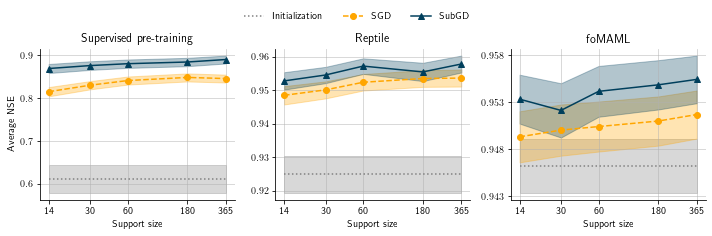

In [12]:
# plot results
style = {
    'normal noise 0.0  maml': {'ls': '--', 'col': '#ffa600', 'marker': 'o', 'label': 'SGD'},
    'pca noise 0.0  maml': {'ls': '-', 'col': '#003f5c', 'marker': '^', 'label': 'SubGD'},
    'normal noise 0.0  supervised': {'ls': '--', 'col': '#ffa600', 'marker': 'o', 'label': 'SGD'},
    'pca noise 0.0  supervised': {'ls': '-', 'col': '#003f5c', 'marker': '^', 'label': 'SubGD'},
    'normal noise 0.0  reptile': {'ls': '--', 'col': '#ffa600', 'marker': 'o', 'label': 'SGD'},
    'pca noise 0.0  reptile': {'ls': '-', 'col': '#003f5c', 'marker': '^', 'label': 'SubGD'},
    'normal metasgd noise 0.0 ': {'ls': '--', 'col': '#bc5090', 'marker': 's', 'label': 'MetaSGD'},
    'no-finetune reptile': {'ls': ':', 'col': 'gray', 'marker': '', 'label': 'Reptile init.'},
    'no-finetune supervised': {'ls': ':', 'col': 'gray', 'marker': '', 'label': 'Supervised init.'},
    'no-finetune maml': {'ls': ':', 'col': 'gray', 'marker': '', 'label': 'Initialization'},
    'no-finetune metasgd': {'ls': ':', 'col': '#bc5090', 'marker': '', 'label': 'MetaSGD init.'},
}
exclude = []
f, axs = plt.subplots(1, 3, figsize=(10, 3), sharey=False, sharex=True)
for i in range(3):
    excl = [['maml', 'reptile', 'metasgd', 'metacurvature'],
            ['maml', 'metasgd', 'supervised', 'metacurvature'],
            ['supervised', 'reptile', 'metasgd', 'metacurvature']]
    i_exclude = [t[1] for t in metrics[0.0].keys() if any(ex in t[1] for ex in excl[i])] + exclude
    f_style = copy.deepcopy(style)
    if i != 2:
        for k in f_style.keys():
            f_style[k]['label'] = None
    reindexed = df_norms.copy()
    reindexed = reindexed.reindex([c for c in reindexed.columns if "no-fine" in c[1]] \
                                  + [c for c in reindexed.columns if "normal" in c[1]] \
                                  + [c for c in reindexed.columns if "pca" in c[1]], axis=1)
    f1 = plot.plot_support_vs_mse(reindexed,
                                 SUPPORT_SIZES,
                                 ranks=False,
                                 aggregation='mean',
                                 exclude_types=i_exclude,
                                 alpha=0.3,
                                 style=f_style,
                                 ax=axs[i],
                                 metric_name='NSE')
    axs[i].get_legend().remove()
    axs[i].set_xscale('log')
    axs[i].set_xticks(SUPPORT_SIZES)
    axs[i].set_xticklabels(SUPPORT_SIZES)
    axs[i].set_xticks([], minor=True)
    if i > 0:
        axs[i].set_ylabel('')
    if i == 2:
        axs[i].set_yticks(np.arange(0.943, 0.958, 0.005))
    axs[i].set_title(['Supervised pre-training', 'Reptile', 'foMAML'][i])
plt.figlegend(frameon=False, loc='lower center', bbox_to_anchor=(0.5, 0.97), ncol=7)
plt.tight_layout()
plt.savefig('plots/hydrology-support-vs-nse-pretraining.pdf', bbox_inches='tight')

In [13]:
# significance test and effect size
from scipy.stats import wilcoxon
p = {}
noise = 0.0
sig_df = df_norms.groupby(['support', 'type'], axis=1).agg(lambda s: s.mean(skipna=False))
best_typs = {support: sig_df.loc[:, support].mean().idxmax(axis=1) for support in SUPPORT_SIZES}
for support, typ in sig_df.columns:
    if typ == f'{best_typs[support]} noise 0.0 ':
        p[(support, typ)] = np.nan
        continue
    if ((sig_df.loc[:, (support, typ)] - sig_df.loc[:, (support, best_typs[support])]) == 0).all():
        p[(support, typ)] = np.nan
        continue
    p[(support, typ)] = wilcoxon(sig_df.loc[:, (support, typ)], sig_df.loc[:, (support, best_typs[support])])[1]
sig_df = pd.DataFrame(p, index=['p-value']).T
sig_df.index.names = ['support', 'type']
display(sig_df.reset_index().pivot(index='type', columns='support', values='p-value').style.format('{:.3e}'))

support,14,30,60,180,365
type,,,,,
no-finetune maml,1.283e-15,1.017e-06,7.414e-12,1.296e-09,4.379e-13
no-finetune reptile,2.854e-19,1.212e-18,1.634e-23,7.740e-22,8.997e-25
no-finetune supervised,1.149e-38,1.149e-38,1.149e-38,1.149e-38,1.149e-38
normal metacurvature noise 0.0,1.872e-29,5.320e-23,9.489e-32,6.990e-27,3.436e-31
normal metasgd noise 0.0,3.946e-06,1.065e-05,2.011e-11,4.278e-07,3.478e-09
normal noise 0.0 maml,7.170e-14,4.435e-03,1.688e-08,4.708e-06,7.101e-08
normal noise 0.0 reptile,1.041e-04,2.547e-15,1.490e-15,4.086e-09,1.894e-14
normal noise 0.0 supervised,1.149e-38,1.149e-38,1.149e-38,1.165e-38,1.149e-38
pca noise 0.0 maml,nan,4.360e-01,4.272e-04,5.185e-03,3.770e-05


In [ ]:
plt.figure(figsize=(4, 3))
finetune_dirs = list((RUNS['maml'] / f'finetune_epoch5000_lr1e-4').glob('hyd*/'))
cfg = Config(RUNS['maml'] / 'config.yml')

f, ax = plot.plot_deltas_rank(cfg, finetune_dirs,
                              tols=[0],
                              ax=plt.gca(),
                              random_baseline=True,
                              n_repeats=1,
                              task_steps=1,
                              within_task_steps=None,
                              epoch_steps=None,
                              use_erank=True,
                              colors=['#003f5c'],
                              plot_details=False,
                              plot_val_metric=False)
plt.tight_layout()
plt.savefig(f'plots/hydrology-erank.pdf', bbox_inches='tight')